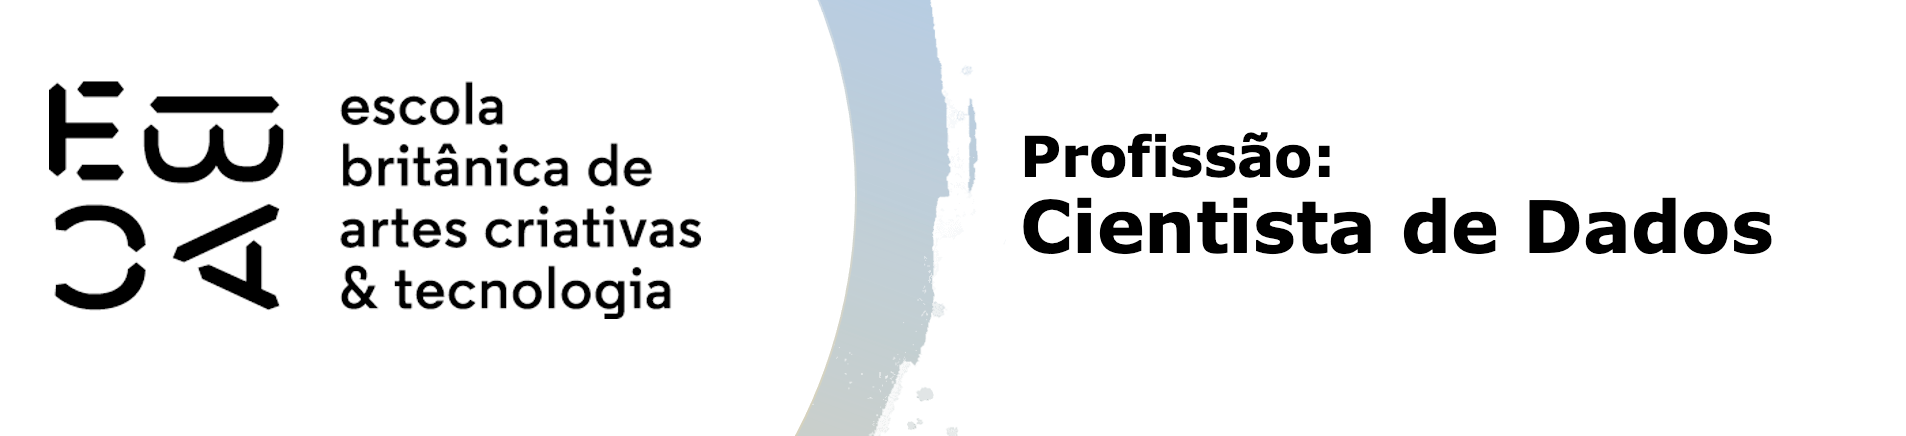

# Tarefa II

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [381]:
import warnings

import pandas                  as pd
import numpy                   as np
import matplotlib.pyplot       as plt
import seaborn                 as sns
import plotly.express          as px
import statsmodels.api         as sm
import statsmodels.formula.api as smf
import xgboost                 as xgb
import scipy.stats             as stats



from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn                              import metrics
from scipy.stats                          import ks_2samp
from scipy.stats                          import t
from sklearn.model_selection              import train_test_split
from sklearn.model_selection              import GridSearchCV
from sklearn.metrics                      import mean_squared_error
from sklearn.impute                       import SimpleImputer
from sklearn.metrics                      import accuracy_score, roc_auc_score, classification_report



In [382]:
warnings.filterwarnings("ignore")

In [383]:
custom_params = {"axes.spines.right":False,"axes.spines.top":False}
sns.set_theme(style='ticks',rc=custom_params)
color_palette = 'mako'
sns.set_palette(sns.color_palette(color_palette))
sns.color_palette(color_palette)

[(0.18195582, 0.11955283, 0.23136943),
 (0.25307401, 0.23772973, 0.48316271),
 (0.21607792, 0.39736958, 0.61948028),
 (0.20344718, 0.56074869, 0.65649508),
 (0.25187832, 0.71827158, 0.67872193),
 (0.54578602, 0.8544913, 0.69848331)]

In [384]:
df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.874,1.000,2515.390,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526,2.000,3180.190,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.244,4.000,1582.290,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.773,2.000,13721.170,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.433,1.000,2891.080,False


In [385]:
df.shape

(750000, 15)

In [386]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   data_ref               750000 non-null  datetime64[ns]
 1   index                  750000 non-null  int64         
 2   sexo                   750000 non-null  object        
 3   posse_de_veiculo       750000 non-null  object        
 4   posse_de_imovel        750000 non-null  object        
 5   qtd_filhos             750000 non-null  int64         
 6   tipo_renda             750000 non-null  object        
 7   educacao               750000 non-null  object        
 8   estado_civil           750000 non-null  object        
 9   tipo_residencia        750000 non-null  object        
 10  idade                  750000 non-null  int64         
 11  tempo_emprego          624043 non-null  float64       
 12  qt_pessoas_residencia  750000 non-null  floa

In [387]:
pd.options.display.float_format = '{:.3f}'.format
df.drop(columns=['data_ref','index']).describe().T

,count,mean,std,min,25%,50%,75%,max
qtd_filhos,750000.000,0.433,0.739,0.000,0.000,0.000,1.000,14.000
idade,750000.000,43.805,11.230,22.000,34.000,43.000,53.000,68.000
tempo_emprego,624043.000,7.749,6.687,0.118,3.049,6.047,10.184,42.907
qt_pessoas_residencia,750000.000,2.212,0.903,1.000,2.000,2.000,3.000,15.000
renda,750000.000,23238.545,79106.014,107.670,3467.700,7861.820,18318.280,4083986.220


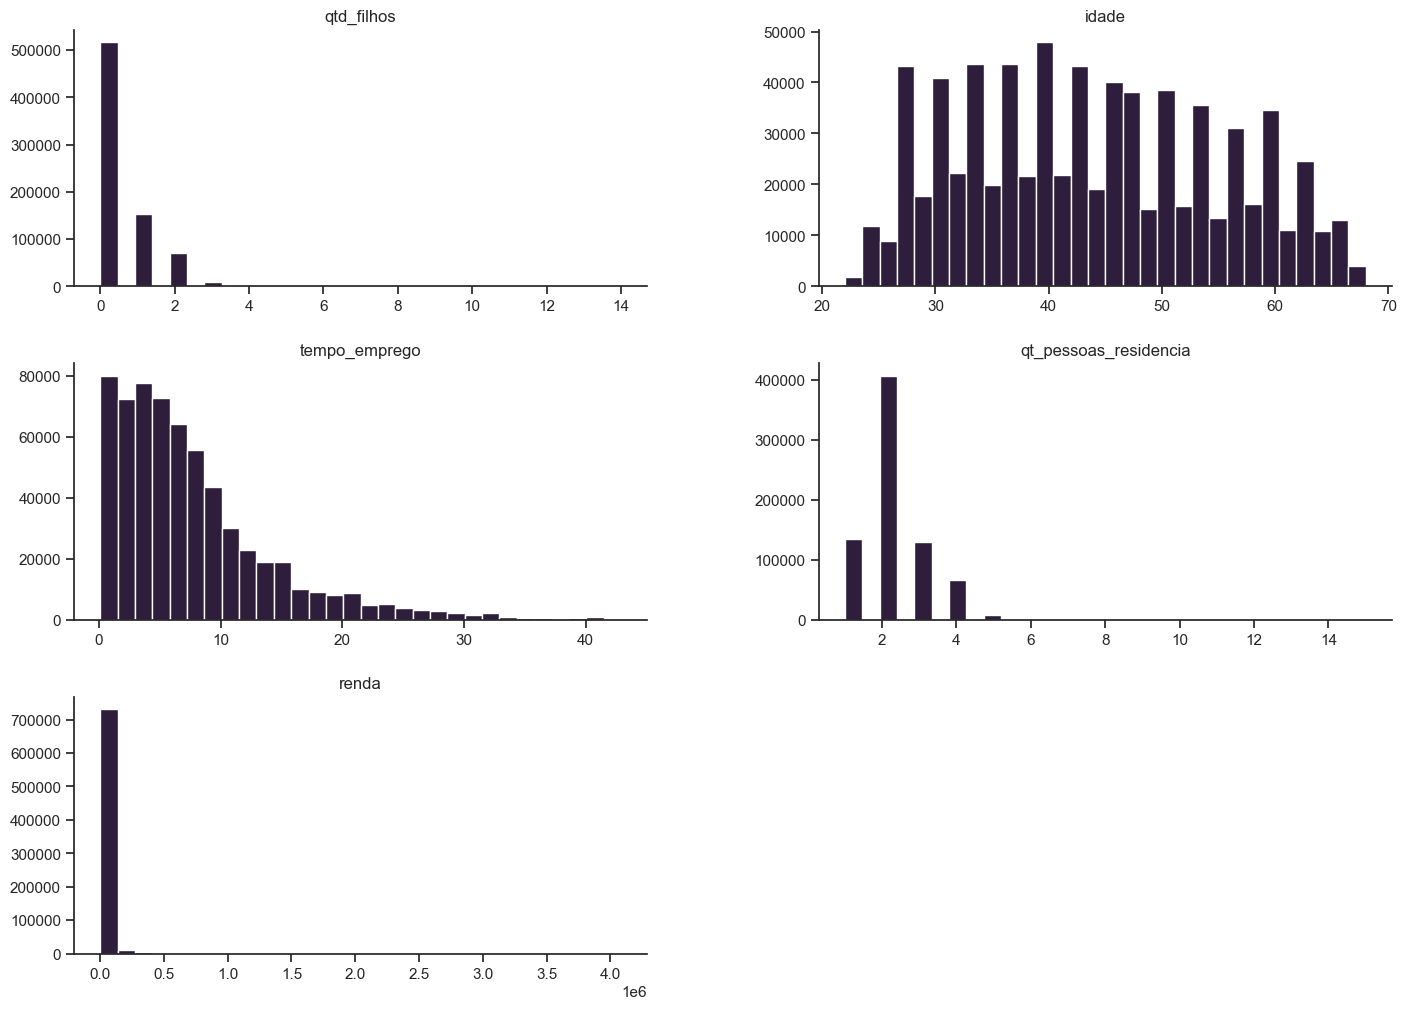

In [388]:
df.drop(columns=['index','data_ref']).hist(bins=30,figsize=(17,12),grid=False);


In [389]:
df.dtypes.to_frame()

,0
data_ref,datetime64[ns]
index,int64
sexo,object
posse_de_veiculo,object
posse_de_imovel,object
qtd_filhos,int64
tipo_renda,object
educacao,object
estado_civil,object
tipo_residencia,object


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [391]:
df = df.sort_values(by='data_ref')

In [392]:
"""O DateOffset do pandas é uma função usada para adicionar ou subtrair períodos de tempo a uma data, 
permitindo realizar operações de deslocamento de tempo em unidades como dias, semanas, meses, anos, entre outros.
Esse método é muito útil quando se deseja manipular datas sem precisar especificar manualmente intervalos específicos."""

#Define a data de corte como três meses antes da data mais recente
data_corte = df.data_ref.max() - pd.DateOffset(months=3)

In [393]:
data_corte

Timestamp('2015-12-01 00:00:00')

In [394]:
df_out_of_time = df[df['data_ref'] > data_corte]
df_treino = df[df['data_ref'] <= data_corte]
df_ = df_treino.copy()

In [395]:
print("Out of Time Data:")
display(df_out_of_time.head())
df_out_of_time.shape

Out of Time Data:


,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
633328,2016-01-01,14658,M,N,S,2,Empresário,Médio,Casado,Casa,43,1.551,4.000,2491.270,False
633329,2016-01-01,15501,F,S,S,1,Empresário,Superior completo,Solteiro,Casa,27,6.792,2.000,1477.180,False
633330,2016-01-01,6093,M,S,S,0,Empresário,Superior completo,Casado,Casa,59,9.997,2.000,5365.120,False
633331,2016-01-01,29,F,N,S,0,Empresário,Superior completo,Separado,Aluguel,46,3.690,1.000,595.500,False
633332,2016-01-01,8359,F,N,S,0,Empresário,Médio,Casado,Casa,39,6.638,2.000,1247.560,True


(150000, 15)

In [396]:
print("\nTraining Data:")
display(df_.head())
df_.shape


Training Data:


,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.874,1.000,2515.390,False
33328,2015-01-01,10265,M,S,S,1,Assalariado,Médio,Casado,Casa,41,8.134,3.000,4979.480,False
33329,2015-01-01,13175,F,N,N,0,Assalariado,Superior completo,Solteiro,Casa,26,1.425,1.000,1285.250,False
33330,2015-01-01,527,M,N,S,1,Assalariado,Superior incompleto,Casado,Casa,37,15.449,3.000,14473.150,False
33331,2015-01-01,14203,F,N,S,1,Assalariado,Médio,Casado,Casa,30,0.370,3.000,1366.630,False


(600000, 15)

## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

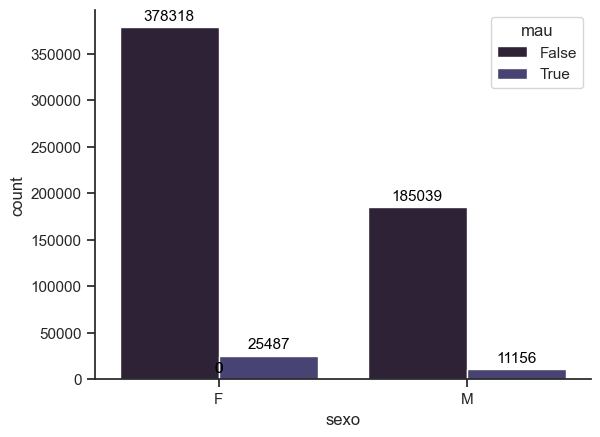

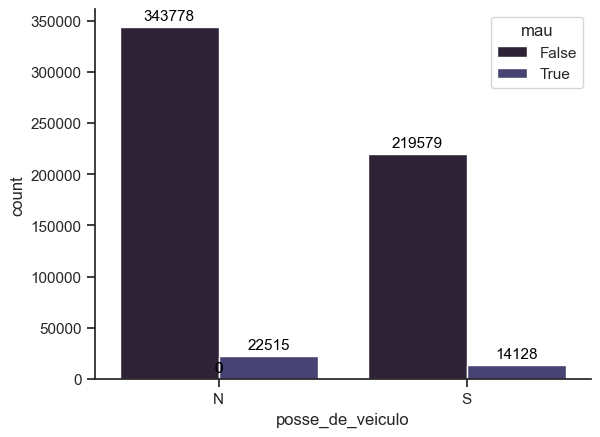

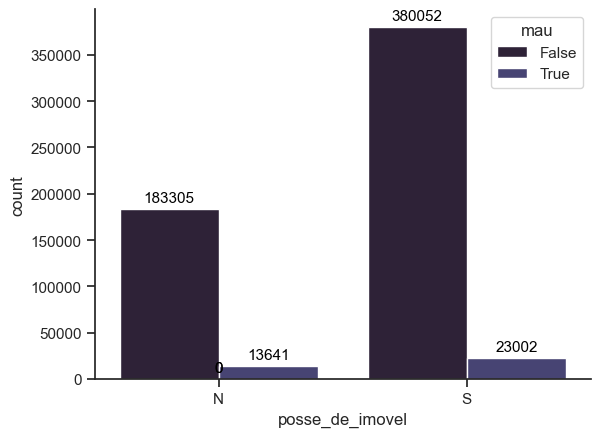

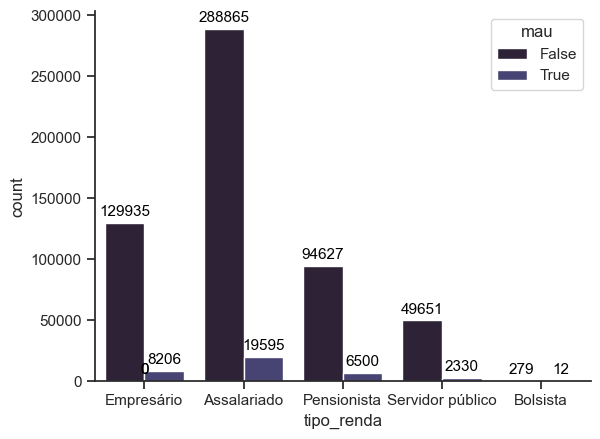

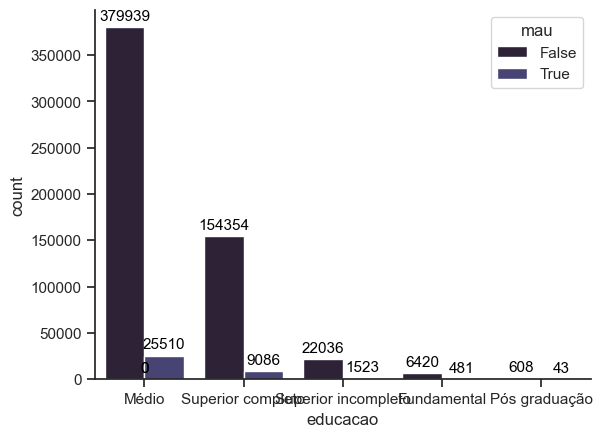

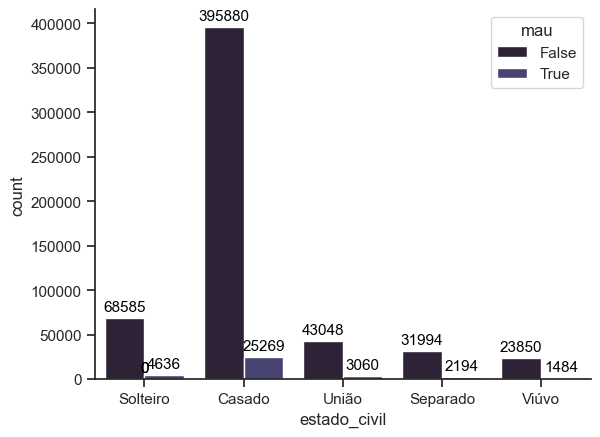

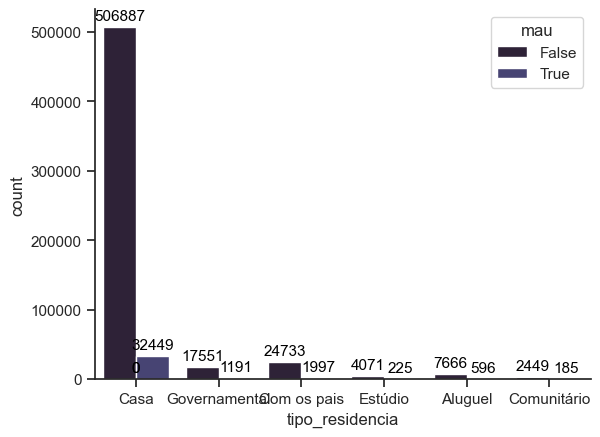

In [398]:
cat = df_.select_dtypes(['object'])
cat_var = cat.columns.tolist()
for var in cat_var:
    fig,ax = plt.subplots()
    ax = sns.countplot(data=df_,x=var,hue='mau')
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}',
                    
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'baseline', 
                fontsize = 11, color = 'black', xytext = (0, 5), 
                textcoords = 'offset points')
    
    plt.show()

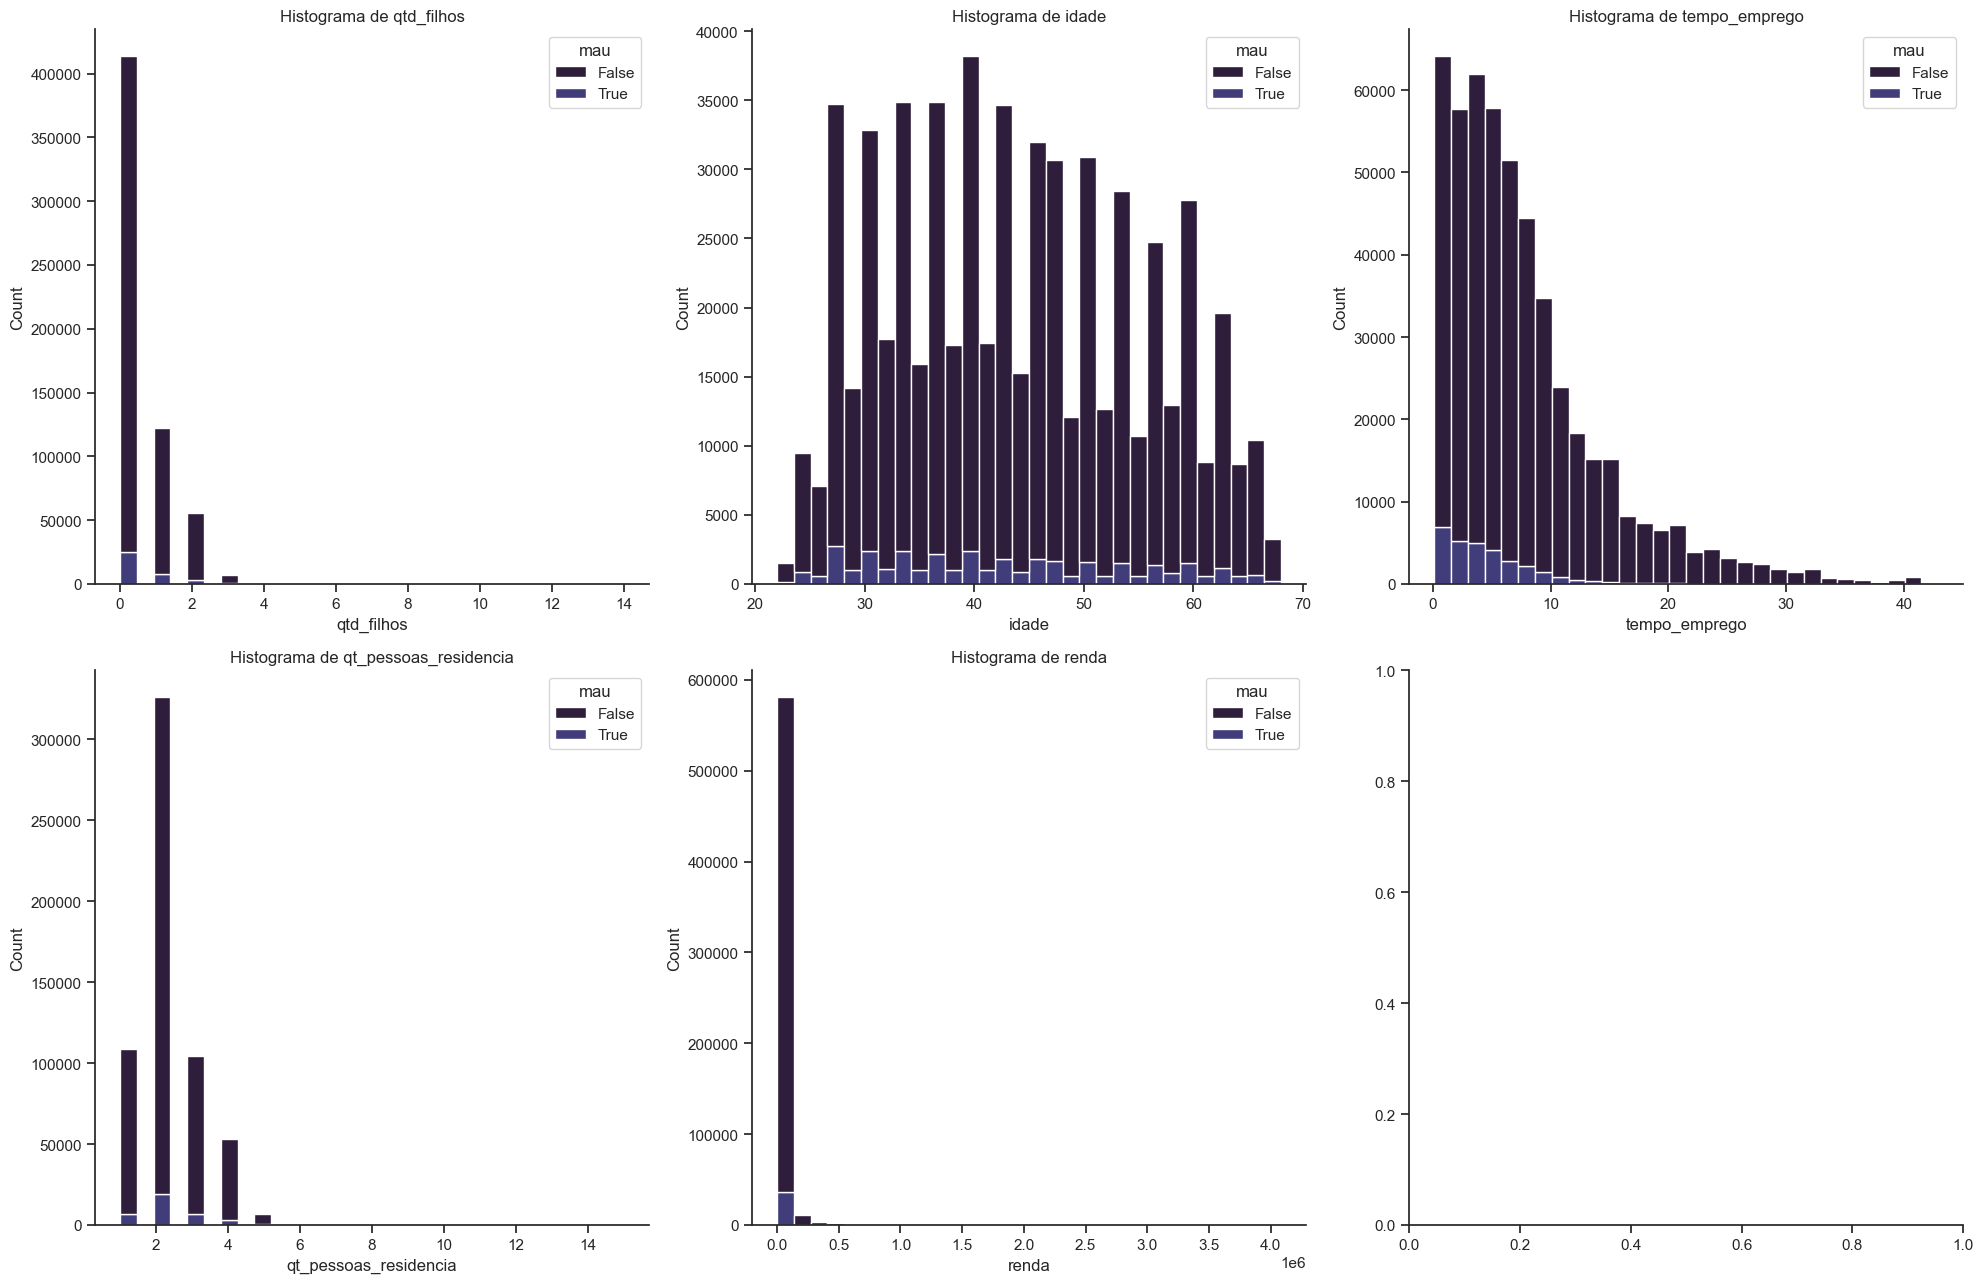

In [399]:
num_cols = df_.select_dtypes(include='number').columns.drop('index')
num_plots = len(num_cols)

fig, axes = plt.subplots(nrows=(num_plots // 3) + 1, ncols=3, figsize=(20, 13))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.histplot(data=df_, x=col, hue='mau', bins=30, ax=axes[i],alpha=1,multiple="stack")
    axes[i].set_title(f'Histograma de {col}')
    axes[i].grid(False)

plt.tight_layout()
plt.show()

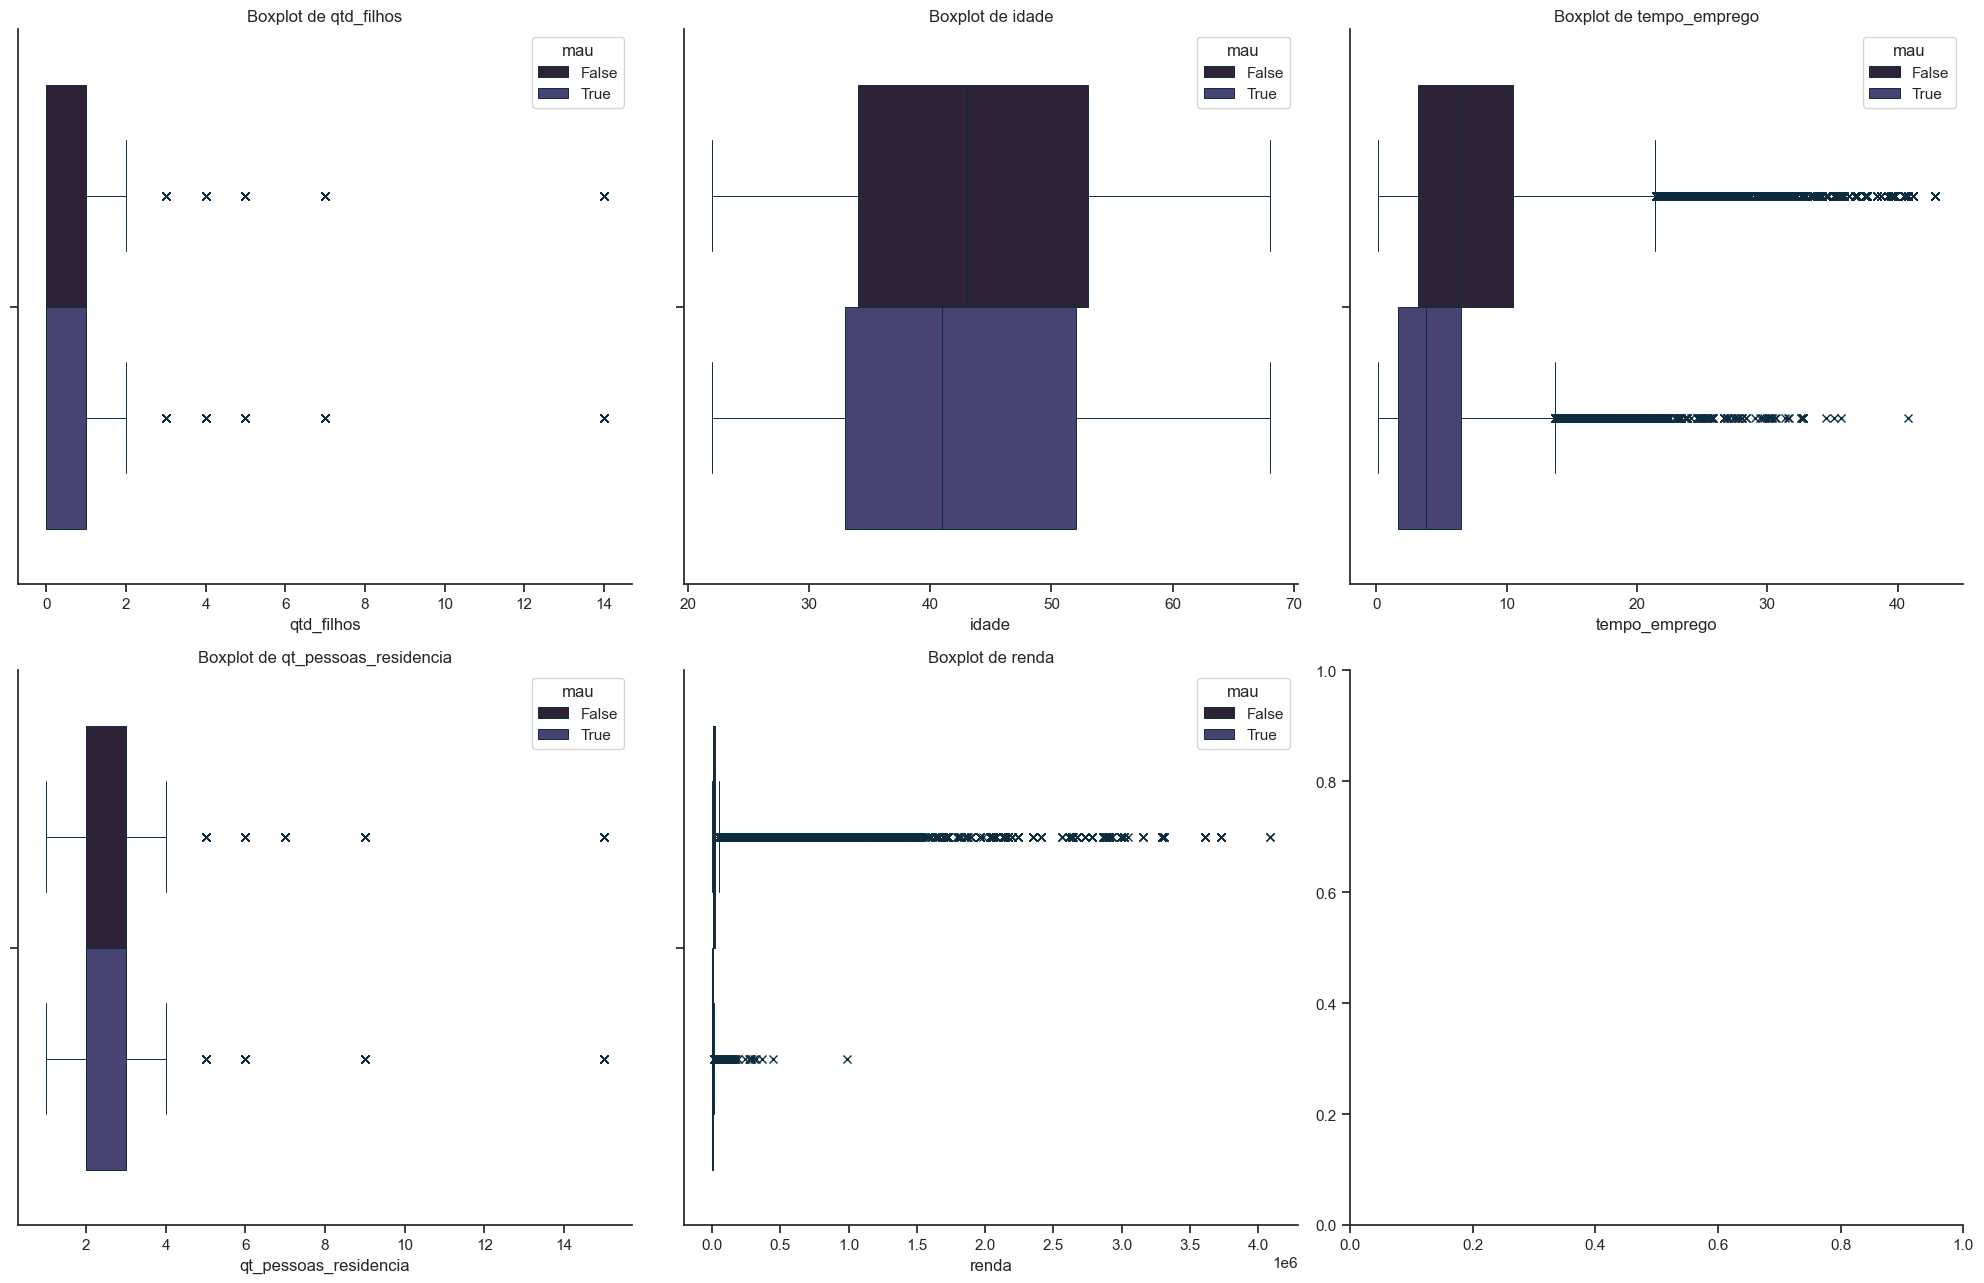

In [400]:

fig, axes = plt.subplots(nrows=(num_plots // 3) + 1, ncols=3, figsize=(20, 13))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.boxplot(data=df_, x=col,linecolor="#0b2d3e",hue='mau', linewidth=.7,flierprops={"marker": "x"}, ax=axes[i])
    axes[i].set_title(f'Boxplot de {col}')
    axes[i].grid(False)

plt.tight_layout()
plt.show()


Número de linhas para cada mês em data_ref:


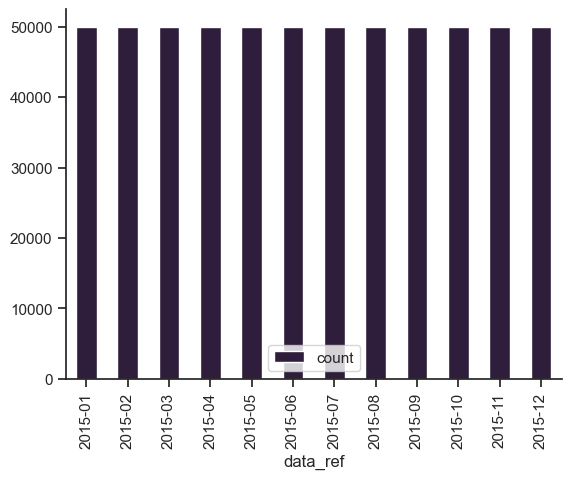

In [401]:
linhas_por_mes = df_['data_ref'].dt.to_period('M').value_counts().sort_index()
print("\nNúmero de linhas para cada mês em data_ref:")
linhas_por_mes.to_frame().plot.bar();

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

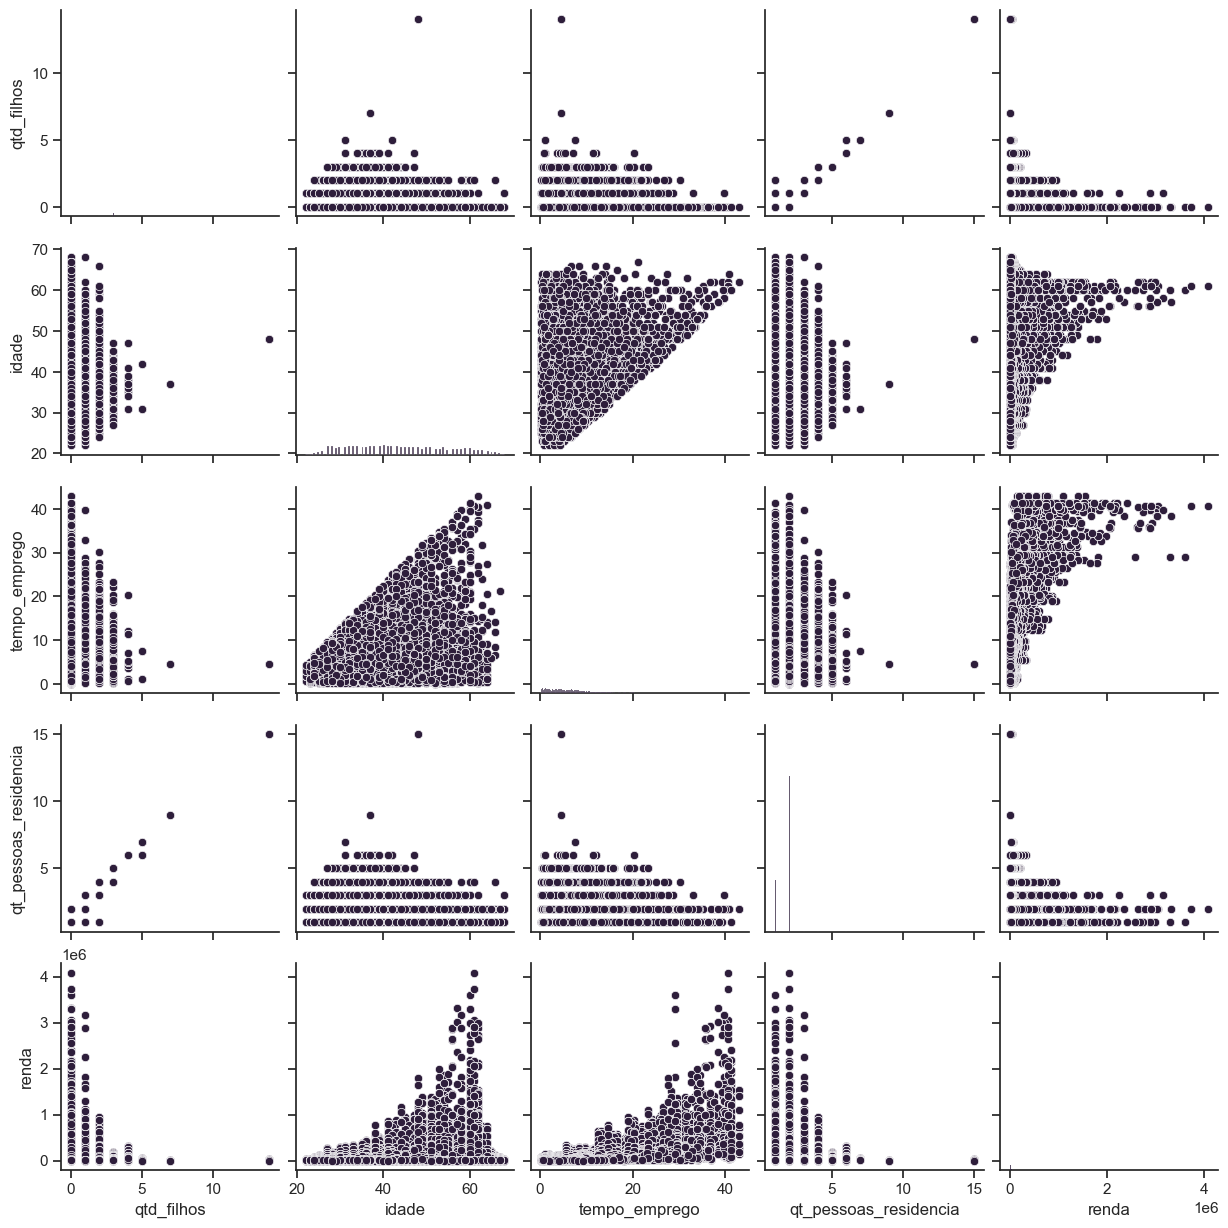

In [403]:
sns.pairplot(data=df_.drop(columns=['index']).select_dtypes(include='number'))

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [405]:
_ = df_.isna().sum().to_frame()
_ / df_.shape[0] * 100

,0
data_ref,0.000
index,0.000
sexo,0.000
posse_de_veiculo,0.000
posse_de_imovel,0.000
qtd_filhos,0.000
tipo_renda,0.000
educacao,0.000
estado_civil,0.000
tipo_residencia,0.000


coluna de tempo contém cerca de 16% de missing em relação ao total de linhas

In [407]:
df.tempo_emprego.describe().to_frame()

,tempo_emprego
count,624043.000
mean,7.749
std,6.687
min,0.118
25%,3.049
50%,6.047
75%,10.184
max,42.907


<Axes: ylabel='Frequency'>

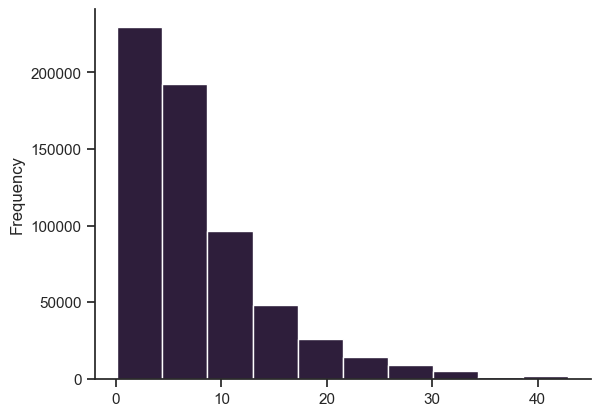

In [408]:
df.tempo_emprego.plot.hist()

16% é algo relevante, vou preencher esse valor faltante com Machine Learning

In [410]:
#Tratando outliers de tempo_emprego e renda passando pra log

df_.loc[:,'renda'] = np.log(df_['renda'])
df_.rename(columns={'renda':'log_renda'},inplace=True)

df_.loc[:,'tempo_emprego'] = np.log(df_['tempo_emprego'])
df_.rename(columns={'tempo_emprego':'log_tempo_emprego'},inplace=True)


In [411]:
df_fill = df_.copy()
df_fill['sexo'] = df_['sexo'].apply(lambda x: 1 if x== 'F' else 0)
df_fill['posse_de_veiculo'] = df_fill['posse_de_veiculo'].apply(lambda x: 1 if x== 'S' else 0)
df_fill['posse_de_imovel'] = df_fill['posse_de_imovel'].apply(lambda x: 1 if x== 'S' else 0)

df_fill = df_fill.drop(columns=['data_ref','index'])
df_fill = pd.get_dummies(df_fill)
df_fill.dropna(inplace=True)

In [412]:
%%time

known_data = df_fill[df_fill['log_tempo_emprego'].notnull()]
unknown_data = df_fill[df_fill['log_tempo_emprego'].isnull()]

X_known = known_data.drop(columns=['log_tempo_emprego'])
y_known = known_data['log_tempo_emprego']

model = xgb.XGBRegressor(n_estimator=70,max_depth=7,learning_rate=0.1)

model.fit(X_known, y_known)


X_unknown = unknown_data.drop(columns=['log_tempo_emprego'])  
predicted_tempo_emprego = model.predict(X_unknown)


df_fill.loc[df_fill['log_tempo_emprego'].isnull(), 'log_tempo_emprego'] = predicted_tempo_emprego

CPU times: total: 24.9 s
Wall time: 4.71 s


In [413]:
lista_index = df_.loc[df_['log_tempo_emprego'].isnull(),:].index.tolist()

df_1 = df_.drop(columns=['log_tempo_emprego'])
df_1['sexo'] = df_['sexo'].apply(lambda x: 1 if x== 'F' else 0)
df_1['posse_de_veiculo'] = df_1['posse_de_veiculo'].apply(lambda x: 1 if x== 'S' else 0)
df_1['posse_de_imovel'] = df_1['posse_de_imovel'].apply(lambda x: 1 if x== 'S' else 0)

df_1 = df_1.drop(columns=['data_ref','index'])
df_1 = pd.get_dummies(df_1)
df_1.iloc[lista_index,:]

predicted = model.predict(df_1.iloc[lista_index,:])
df_.loc[df_['log_tempo_emprego'].isna(),'log_tempo_emprego'] = predicted
df_.log_tempo_emprego.isna().sum()

0

In [414]:
metadados = (df_
             .drop(columns=['data_ref','index'])
             .dtypes
             .to_frame()
             .rename(columns={0:'dtype'})
            )
metadados['nmissings'] = df_.isna().sum()
metadados['unique_val'] = df_.nunique()
metadados

,dtype,nmissings,unique_val
sexo,object,0,2
posse_de_veiculo,object,0,2
posse_de_imovel,object,0,2
qtd_filhos,int64,0,8
tipo_renda,object,0,5
educacao,object,0,5
estado_civil,object,0,5
tipo_residencia,object,0,6
idade,int64,0,47
log_tempo_emprego,float64,0,55194


In [415]:
def IV(variavel, resposta):
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

    rótulo_evento = tab.columns[0]
    rótulo_nao_evento = tab.columns[1]

    tab['pct_evento'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    tab['ep'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    
    tab['pct_nao_evento'] = tab[rótulo_nao_evento]/tab.loc['total',rótulo_nao_evento]
    tab['woe'] = np.log(tab.pct_evento/tab.pct_nao_evento)
    tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.woe
    return tab['iv_parcial'].sum()

In [416]:
iv_sexo = IV(df_.sexo, df_.mau)
print(f'IV da variável SEXO: {iv_sexo:.1%}')

IV da variável SEXO: 0.3%


In [417]:
metadados = (df_
             .drop(columns=['data_ref','index'])
             .dtypes
             .to_frame()
             .rename(columns={0:'dtype'})
            )
metadados['nmissings'] = df_.isna().sum()
metadados['unique_val'] = df_.nunique()
metadados['papel'] = 'covariavel'
metadados.loc['mau','papel'] = 'resposta'
metadados.loc['bom','papel'] = 'resposta'
metadados

,dtype,nmissings,unique_val,papel
sexo,object,0.000,2.000,covariavel
posse_de_veiculo,object,0.000,2.000,covariavel
posse_de_imovel,object,0.000,2.000,covariavel
qtd_filhos,int64,0.000,8.000,covariavel
tipo_renda,object,0.000,5.000,covariavel
educacao,object,0.000,5.000,covariavel
estado_civil,object,0.000,5.000,covariavel
tipo_residencia,object,0.000,6.000,covariavel
idade,int64,0.000,47.000,covariavel
log_tempo_emprego,float64,0.000,55194.000,covariavel


In [418]:
var='idade'
IV(pd.qcut(df_[var],5,duplicates='drop'), df_.mau)

0.018434212949962638

In [419]:
for var in metadados[metadados.papel=='covariavel'].index:
    if  (metadados.loc[var, 'unique_val']>6):
        metadados.loc[var, 'IV'] = IV(pd.qcut(df_[var],5,duplicates='drop'), df_.mau)
    else: 
        metadados.loc[var, 'IV'] = IV(df_[var], df_.mau)

    
metadados

,dtype,nmissings,unique_val,papel,IV
sexo,object,0.000,2.000,covariavel,0.003
posse_de_veiculo,object,0.000,2.000,covariavel,0.000
posse_de_imovel,object,0.000,2.000,covariavel,0.010
qtd_filhos,int64,0.000,8.000,covariavel,0.000
tipo_renda,object,0.000,5.000,covariavel,0.010
educacao,object,0.000,5.000,covariavel,0.004
estado_civil,object,0.000,5.000,covariavel,0.001
tipo_residencia,object,0.000,6.000,covariavel,0.003
idade,int64,0.000,47.000,covariavel,0.018
log_tempo_emprego,float64,0.000,55194.000,covariavel,0.278



|Faixa|Poder preditivo|
|:-|:-|
|0 a 0,02| Inútil |
|0,02 a 0,1| Fraco |
|0,1 a 0,3| Médio |
|0,3 a 0,5| Forte |
|0,5 ou mais| Suspeito de tão alto |

In [421]:
a = metadados.drop(index=['bom','mau'])


<Axes: xlabel='None', ylabel='IV'>

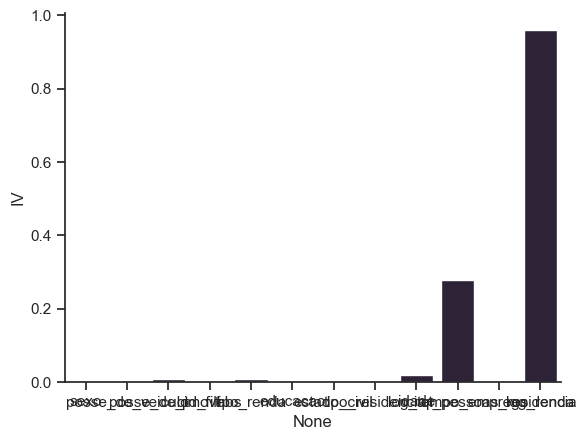

In [422]:
sns.barplot(data=a,y='IV',x=a.index)


In [423]:
def biv_discreta(var, df):
    df['bom'] = 1-df.mau
    g = df.groupby(var)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(), 
                        var: g['mau'].mean().index, 
                        'cont':g[var].count()})
    
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(biv[var], biv.woe, ':c', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:m', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:m', label='limite inferior')
    
    num_cat = biv.shape[0]
    ax[0].set_xlim([-.3, num_cat-.7])

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax[0].set_xticks(list(range(num_cat)))
    ax[0].set_xticklabels(biv[var], rotation=15)
    
    ax[1] = biv.cont.plot.bar()
    return biv

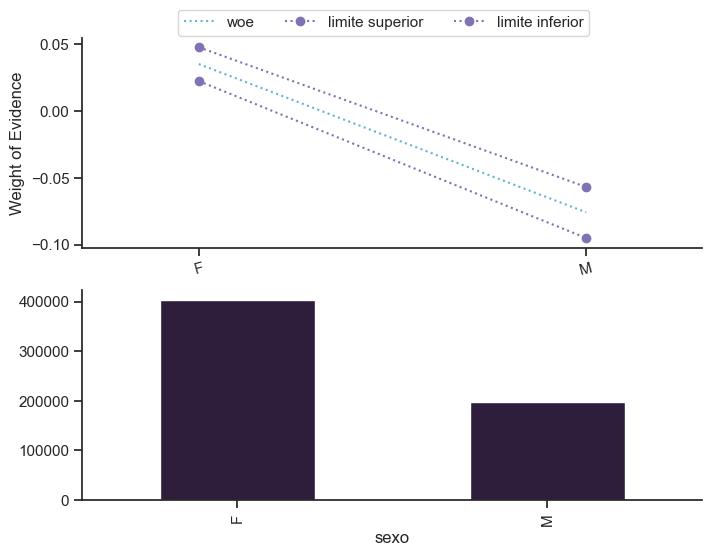

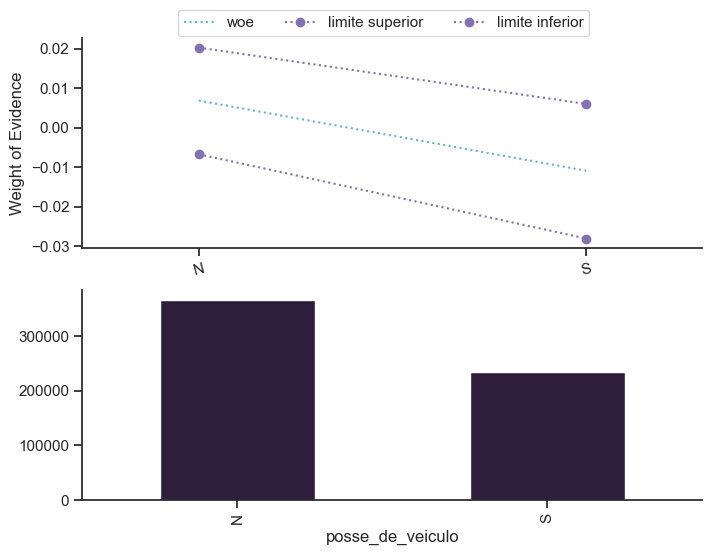

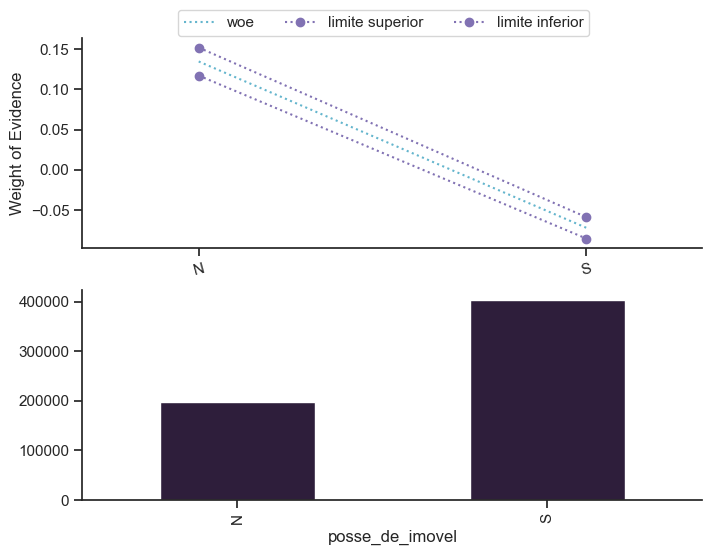

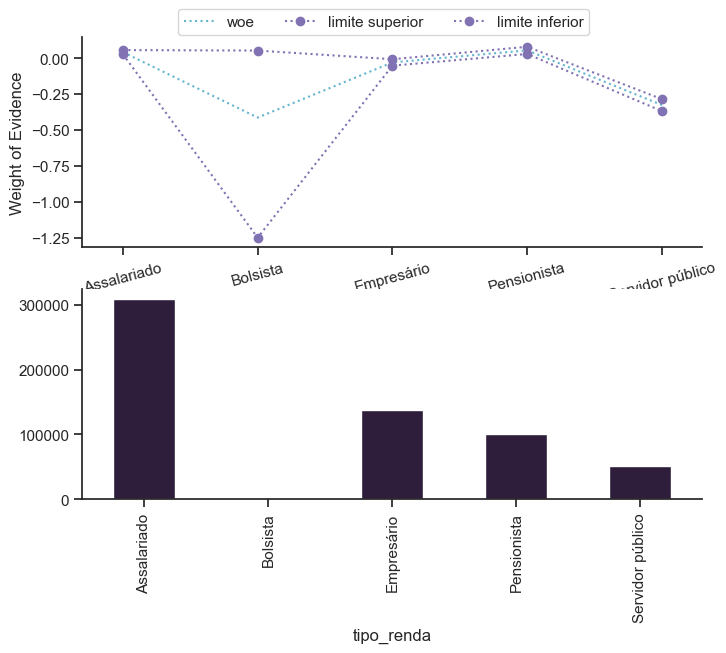

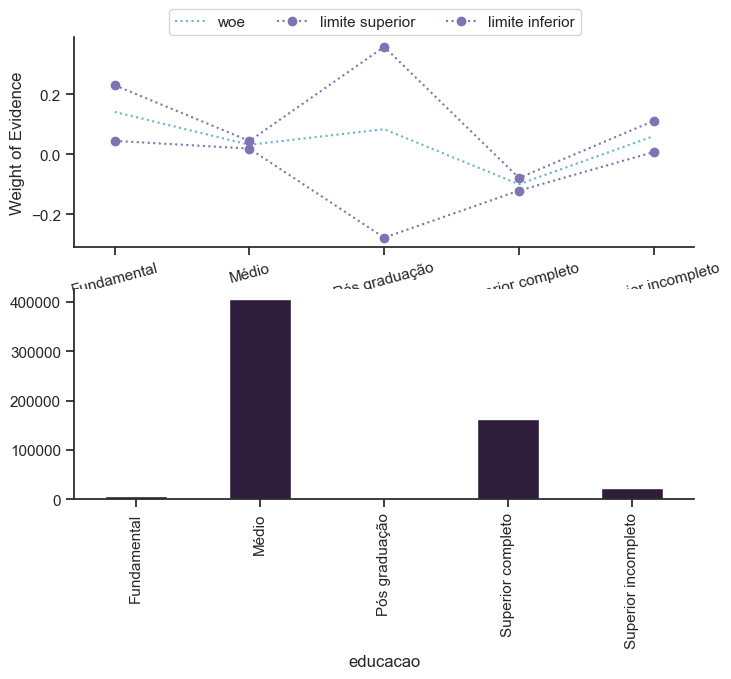

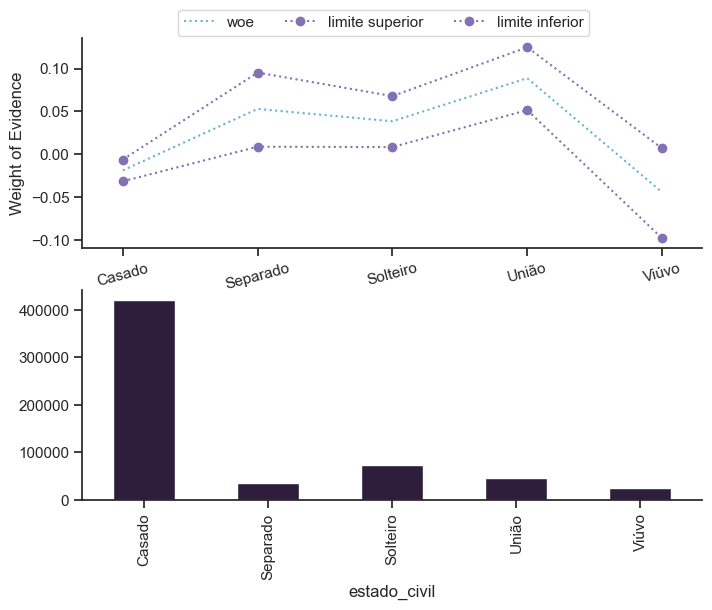

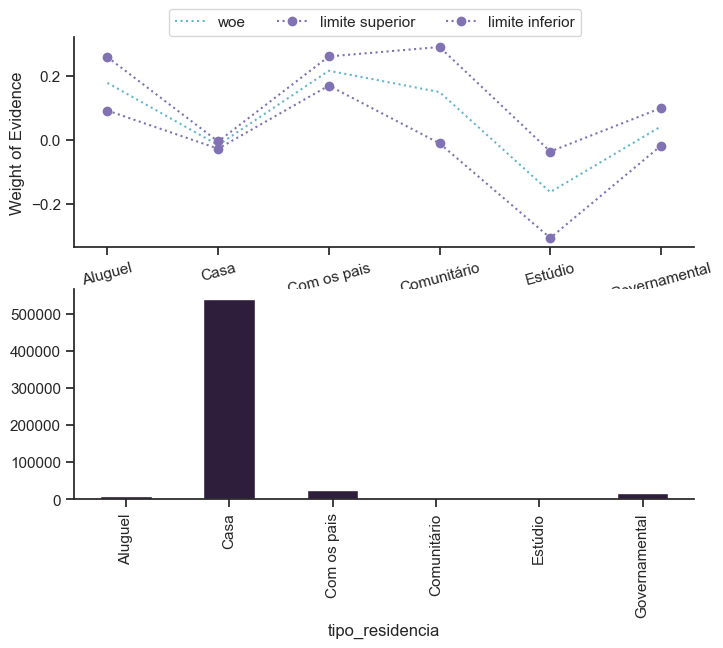

In [424]:

for var in df_.select_dtypes(['object']):
    biv_discreta(var, df_);

,qt_bom,qt_mau,mau,tipo_renda,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_renda,,,,,,,,,,,,,,
Assalariado,288865,19595,0.064,Assalariado,308460,0.000,0.064,0.063,-2.691,-2.676,-2.705,0.042,0.056,0.027
Empresário,129935,8206,0.059,Empresário,138141,0.001,0.061,0.058,-2.762,-2.740,-2.785,-0.029,-0.007,-0.052
Pensionista,94627,6500,0.064,Pensionista,101127,0.001,0.066,0.063,-2.678,-2.653,-2.704,0.055,0.079,0.029
Serv_P/Bols.,49930,2342,0.045,Serv_P/Bols.,52272,0.001,0.047,0.043,-3.060,-3.019,-3.102,-0.327,-0.286,-0.369


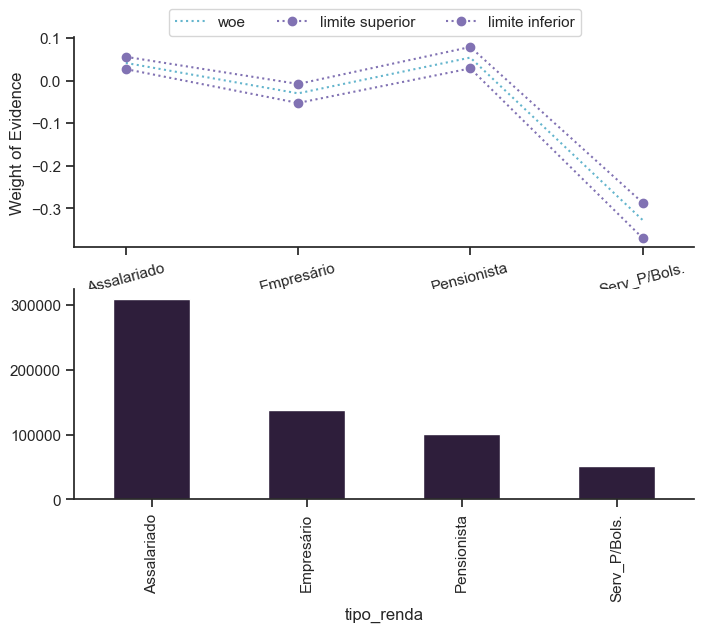

In [425]:
df2 = df_.copy()
df2.tipo_renda.replace({'Bolsista': 'Serv_P/Bols.', 'Servidor público': 'Serv_P/Bols.'}, inplace=True)
biv_discreta('tipo_renda', df2)

,qt_bom,qt_mau,mau,educacao,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
educacao,,,,,,,,,,,,,,
Médio/Fund,386359,25991,0.063,Médio/Fund,412350,0.000,0.064,0.062,-2.699,-2.687,-2.712,0.034,0.046,0.021
Sup_comp/incomp/Pos,176998,10652,0.057,Sup_comp/incomp/Pos,187650,0.001,0.058,0.056,-2.810,-2.791,-2.830,-0.078,-0.058,-0.097


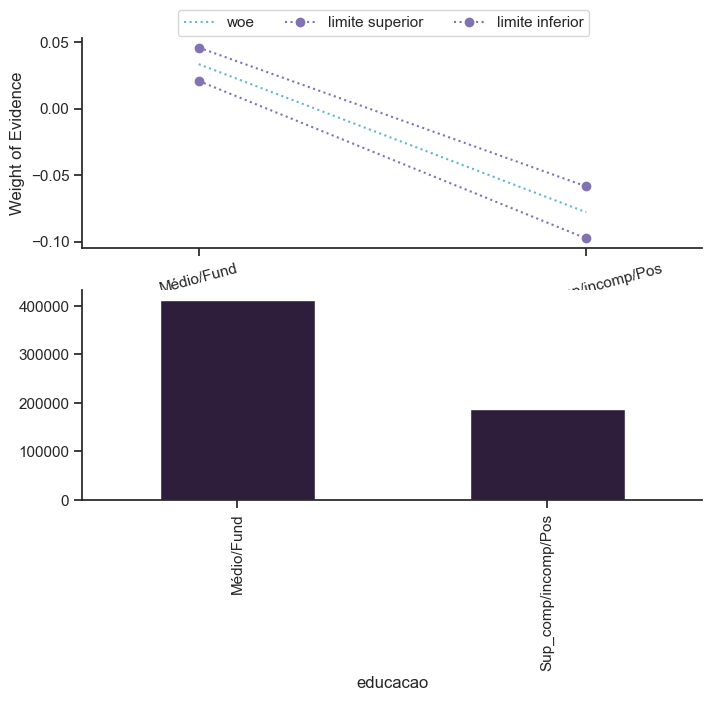

In [426]:
df2.educacao.replace({'Médio': 'Médio/Fund', 'Fundamental': 'Médio/Fund','Superior completo':'Sup_comp/incomp/Pos','Superior incompleto':'Sup_comp/incomp/Pos','Pós graduação':'Sup_comp/incomp/Pos'}, inplace=True)
biv_discreta('educacao', df2)

,qt_bom,qt_mau,mau,tipo_residencia,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_residencia,,,,,,,,,,,,,,
Aluguel,7666,596,0.072,Aluguel,8262,0.003,0.078,0.067,-2.554,-2.474,-2.641,0.178,0.259,0.092
Casa,506887,32449,0.060,Casa,539336,0.000,0.061,0.060,-2.749,-2.737,-2.760,-0.016,-0.005,-0.027
Gov/c_pais/estud/comun,48804,3598,0.069,Gov/c_pais/estud/comun,52402,0.001,0.071,0.066,-2.607,-2.574,-2.642,0.125,0.159,0.091


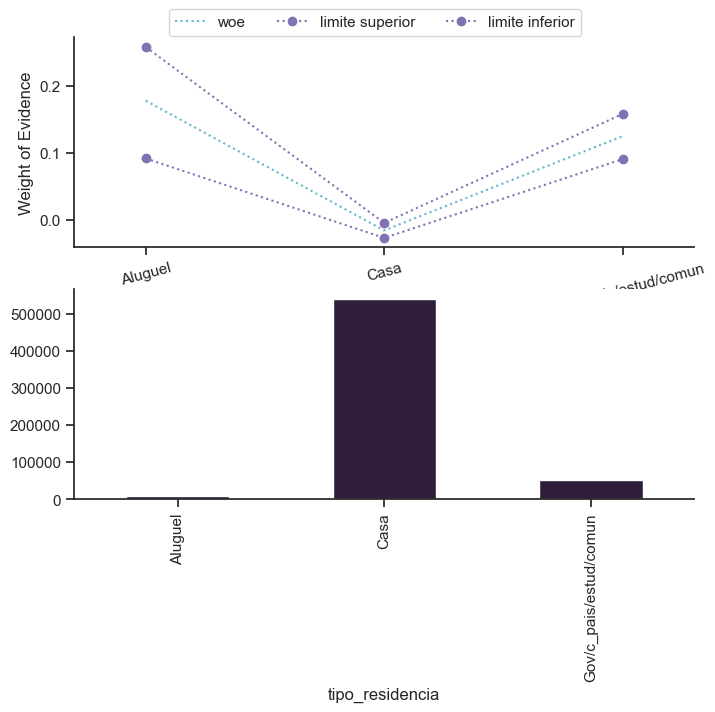

In [427]:
df2.tipo_residencia.replace({'Governamental':'Gov/c_pais/estud/comun','Com os pais':'Gov/c_pais/estud/comun','Estúdio':'Gov/c_pais/estud/comun','Comunitário':'Gov/c_pais/estud/comun'}, inplace=True)
biv_discreta('tipo_residencia', df2)

,qt_bom,qt_mau,mau,estado_civil,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
estado_civil,,,,,,,,,,,,,,
Casado/União,438928,28329,0.061,Casado/União,467257,0.000,0.061,0.060,-2.740,-2.728,-2.753,-0.008,0.004,-0.020
Separado/Solteiro,100579,6830,0.064,Separado/Solteiro,107409,0.001,0.065,0.062,-2.690,-2.665,-2.714,0.043,0.067,0.018
Viúvo,23850,1484,0.059,Viúvo,25334,0.001,0.061,0.056,-2.777,-2.726,-2.831,-0.044,0.007,-0.098


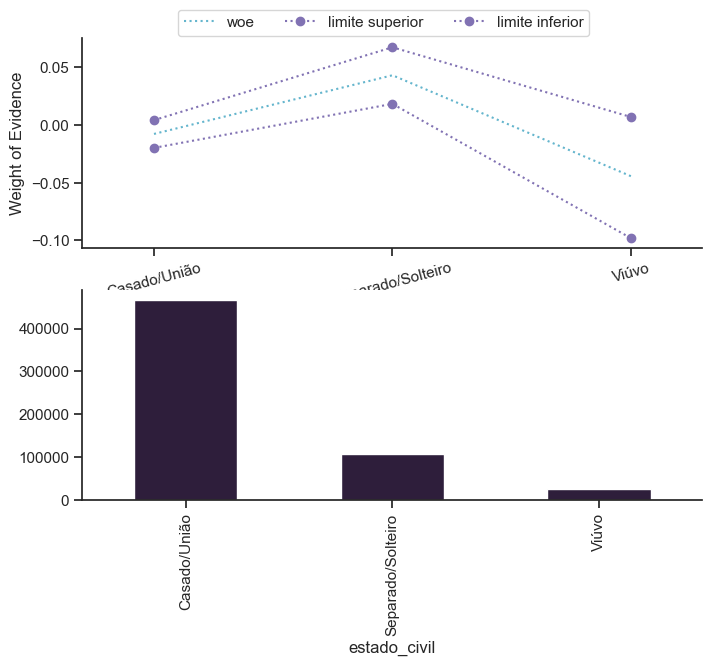

In [428]:
df2.estado_civil.replace({'Casado':'Casado/União','União':'Casado/União','Separado':'Separado/Solteiro','Solteiro':'Separado/Solteiro'}, inplace=True)
biv_discreta('estado_civil', df2)

In [429]:
df2.estado_civil.unique()

array(['Separado/Solteiro', 'Casado/União', 'Viúvo'], dtype=object)

In [430]:
def biv_continua(var, ncat, df):
    df['bom'] = 1-df.mau
    cat_srs, bins = pd.qcut(df[var], ncat, retbins=True, precision=0, duplicates='drop')
    g = df.groupby(cat_srs)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(), 
                        var: g[var].mean(), 
                        'cont':g[var].count()})
    
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(biv[var], biv.woe, ':c', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:m', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:m', label='limite inferior')
    
    num_cat = biv.shape[0]

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax[1] = biv.cont.plot.bar()
    return None

In [431]:
metadados

,dtype,nmissings,unique_val,papel,IV
sexo,object,0.000,2.000,covariavel,0.003
posse_de_veiculo,object,0.000,2.000,covariavel,0.000
posse_de_imovel,object,0.000,2.000,covariavel,0.010
qtd_filhos,int64,0.000,8.000,covariavel,0.000
tipo_renda,object,0.000,5.000,covariavel,0.010
educacao,object,0.000,5.000,covariavel,0.004
estado_civil,object,0.000,5.000,covariavel,0.001
tipo_residencia,object,0.000,6.000,covariavel,0.003
idade,int64,0.000,47.000,covariavel,0.018
log_tempo_emprego,float64,0.000,55194.000,covariavel,0.278


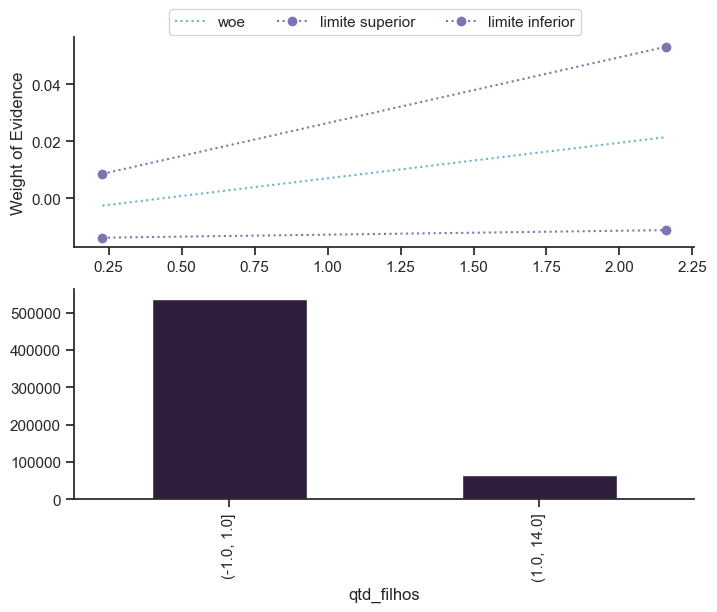

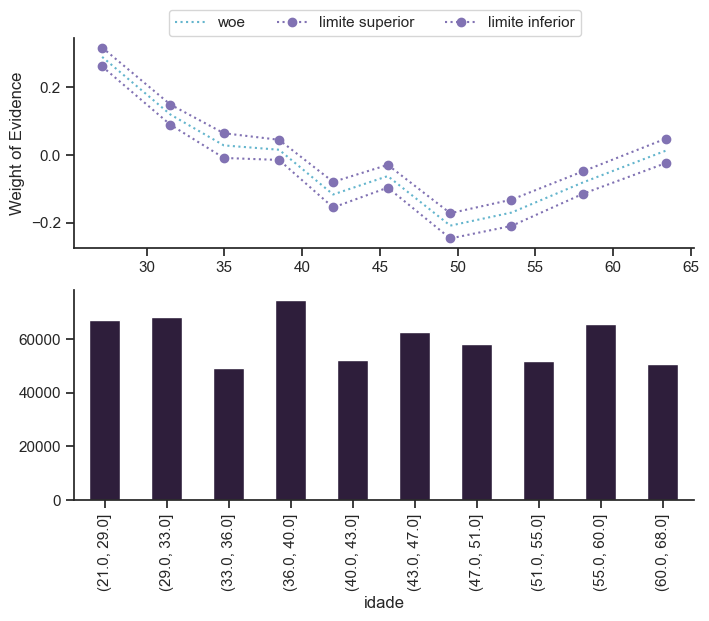

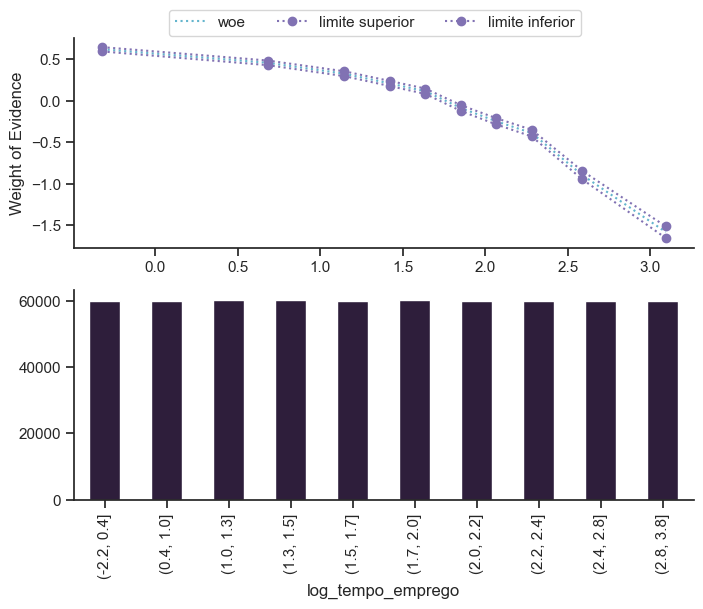

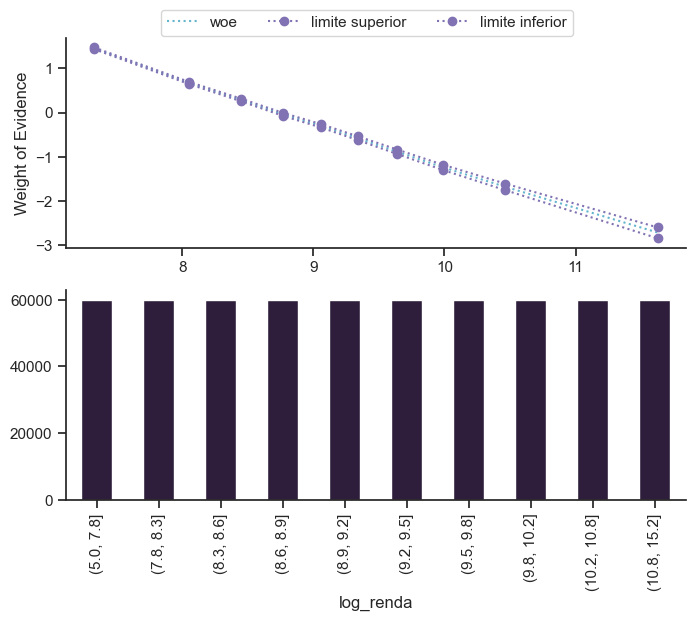

In [432]:
biv_continua('qtd_filhos', 4, df_)

biv_continua('idade', 10, df_)

biv_continua('log_tempo_emprego', 10, df_)

biv_continua('log_renda', 10, df_)

---

In [434]:
df['mau'] = df.mau.astype('int64')
df_.loc[:,'mau'] = df_.mau.astype('int64')

In [435]:
#Ponderações
df_amostra = pd.concat([df[df.mau==1], df[df.mau==0].sample(n=58643)])
tab_am = df_amostra.mau.value_counts()
tab_am

mau
1    58643
0    58643
Name: count, dtype: int64

In [436]:
tab_pop = df.mau.value_counts()
tab_pop

mau
0    691357
1     58643
Name: count, dtype: int64

In [437]:
rho_mau = tab_am.loc[1]/tab_am.sum()
rho_bom = tab_am.loc[0]/tab_am.sum()

pi_mau = tab_pop.loc[1]/tab_pop.sum()
pi_bom = tab_pop.loc[0]/tab_pop.sum()

wbom = pi_bom*rho_bom
wmau = pi_mau*rho_mau

print(f'wbom= {wbom}, wmau={wmau}')

wbom= 0.4609046666666667, wmau=0.039095333333333336


In [438]:
df_amostra.loc[df_amostra.mau == 1,'w']=wmau
df_amostra.loc[df_amostra.mau == 0,'w']=wbom

In [439]:
df_amostra.groupby('mau')['w'].sum()/df_amostra.w.sum()

mau
0   0.922
1   0.078
Name: w, dtype: float64

In [440]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 600000 entries, 0 to 566667
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   data_ref               600000 non-null  datetime64[ns]
 1   index                  600000 non-null  int64         
 2   sexo                   600000 non-null  object        
 3   posse_de_veiculo       600000 non-null  object        
 4   posse_de_imovel        600000 non-null  object        
 5   qtd_filhos             600000 non-null  int64         
 6   tipo_renda             600000 non-null  object        
 7   educacao               600000 non-null  object        
 8   estado_civil           600000 non-null  object        
 9   tipo_residencia        600000 non-null  object        
 10  idade                  600000 non-null  int64         
 11  log_tempo_emprego      600000 non-null  float64       
 12  qt_pessoas_residencia  600000 non-null  float64  

---

In [442]:
formula = '''
    mau ~  posse_de_veiculo + posse_de_imovel + qtd_filhos + tipo_renda + 
    educacao + estado_civil + tipo_residencia + idade + log_tempo_emprego +  
    qt_pessoas_residencia 
'''

rl = smf.glm(formula, data=df2, family=sm.families.Binomial()).fit()

print(rl.summary())

df2['score'] = rl.predict(df2)

acc = metrics.accuracy_score(df2.mau, df2.score>.068)
fpr, tpr, thresholds = metrics.roc_curve(df2.mau, df2.score)
auc = metrics.auc(fpr, tpr)
gini = 2*auc -1
ks = ks_2samp(df2.loc[df2.mau == 1, 'score'], df2.loc[df2.mau != 1, 'score']).statistic

print('Acurácia: {0:.1%} \nAUC: {1:.1%} \nGINI: {2:.1%}\nKS: {3:.1%}'
      .format(acc, auc, gini, ks))

                      Generalized Linear Model Regression Results                      
Dep. Variable:     ['mau[False]', 'mau[True]']   No. Observations:               600000
Model:                                     GLM   Df Residuals:                   599985
Model Family:                         Binomial   Df Model:                           14
Link Function:                           Logit   Scale:                          1.0000
Method:                                   IRLS   Log-Likelihood:            -1.3387e+05
Date:                         Sat, 02 Nov 2024   Deviance:                   2.6775e+05
Time:                                 19:05:12   Pearson chi2:                 5.84e+05
No. Iterations:                              6   Pseudo R-squ. (CS):            0.01347
Covariance Type:                     nonrobust                                         
                                                coef    std err          z      P>|z|      [0.025      0.975]
----------

In [443]:
formula = '''
    mau ~ sexo + posse_de_veiculo + posse_de_imovel + qtd_filhos + tipo_renda + 
    educacao + estado_civil + tipo_residencia + idade + log_tempo_emprego +  
    qt_pessoas_residencia
'''

rl = smf.glm(formula, data=df_, family=sm.families.Binomial()).fit()

print(rl.summary())

df_['score'] = rl.predict(df_)

acc = metrics.accuracy_score(df_.mau, df_.score>.068)
fpr, tpr, thresholds = metrics.roc_curve(df_.mau, df_.score)
auc = metrics.auc(fpr, tpr)
gini = 2*auc -1
ks = ks_2samp(df_.loc[df_.mau == 1, 'score'], df_.loc[df_.mau != 1, 'score']).statistic

print('Acurácia: {0:.1%} \nAUC: {1:.1%} \nGINI: {2:.1%}\nKS: {3:.1%}'
      .format(acc, auc, gini, ks))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    mau   No. Observations:               600000
Model:                            GLM   Df Residuals:                   599975
Model Family:                Binomial   Df Model:                           24
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.3368e+05
Date:                Sat, 02 Nov 2024   Deviance:                   2.6737e+05
Time:                        19:06:05   Pearson chi2:                 5.86e+05
No. Iterations:                     6   Pseudo R-squ. (CS):            0.01410
Covariance Type:            nonrobust                                         
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

In [444]:
df_.columns

Index(['data_ref', 'index', 'sexo', 'posse_de_veiculo', 'posse_de_imovel',
       'qtd_filhos', 'tipo_renda', 'educacao', 'estado_civil',
       'tipo_residencia', 'idade', 'log_tempo_emprego',
       'qt_pessoas_residencia', 'log_renda', 'mau', 'bom', 'score'],
      dtype='object')

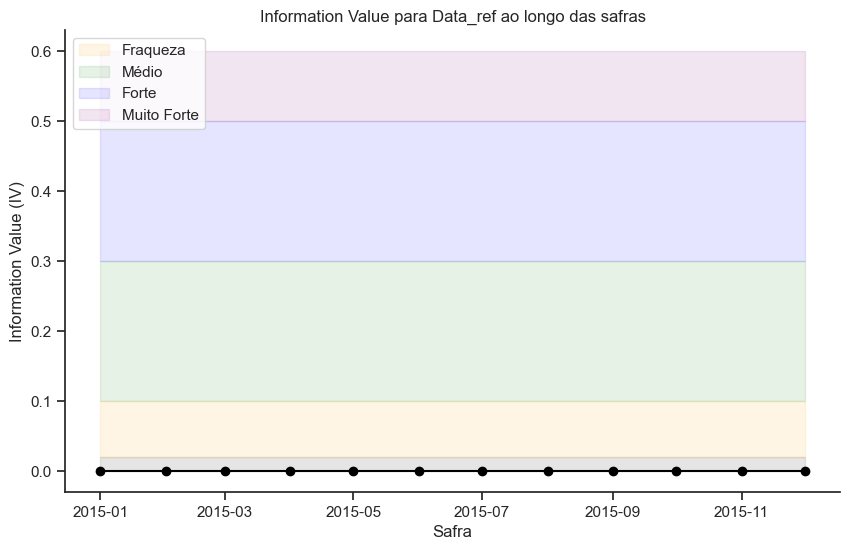

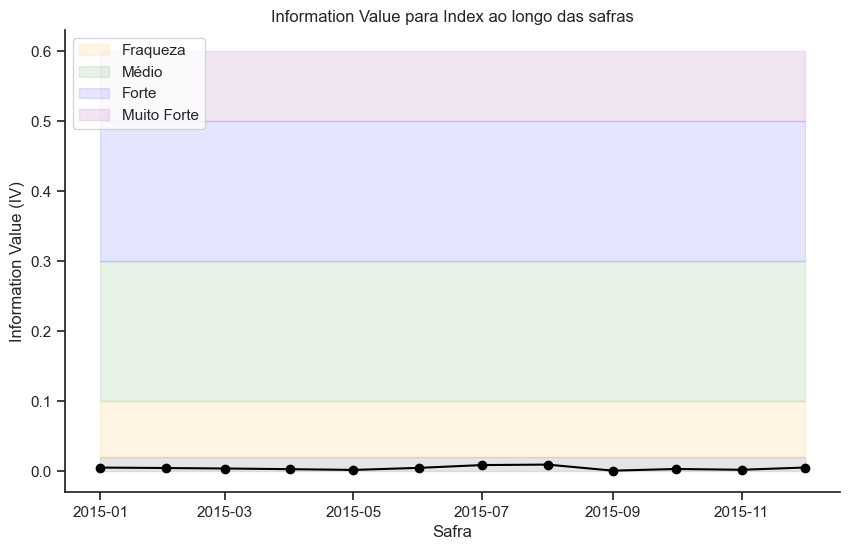

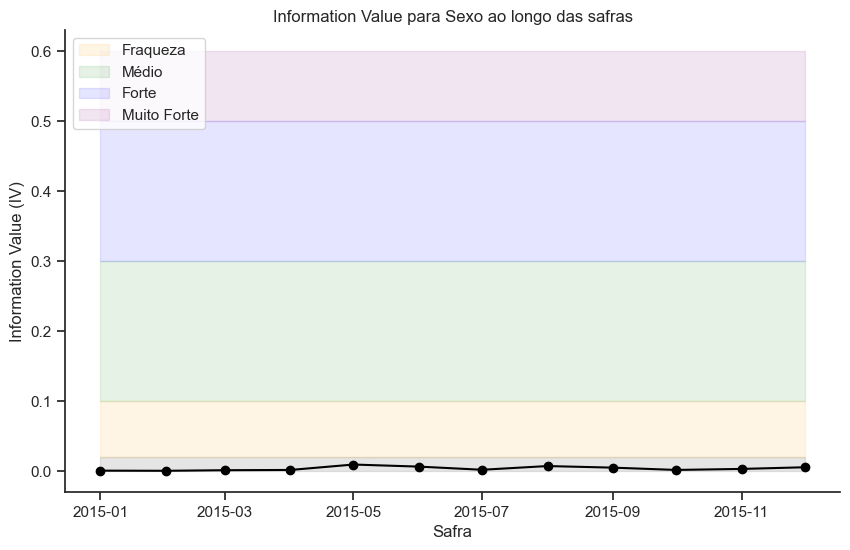

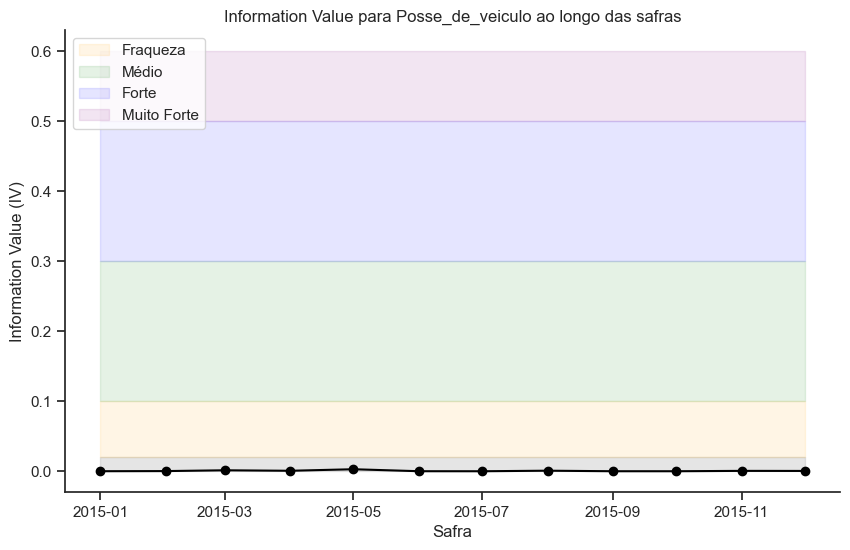

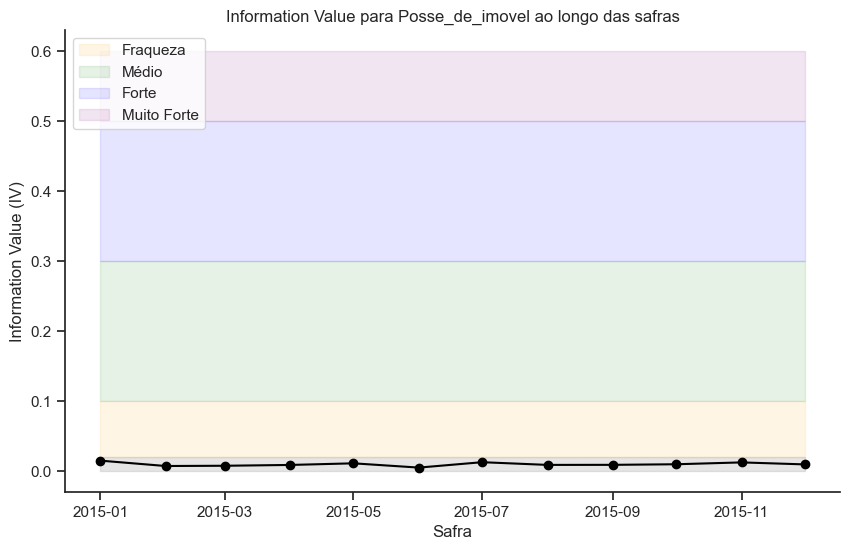

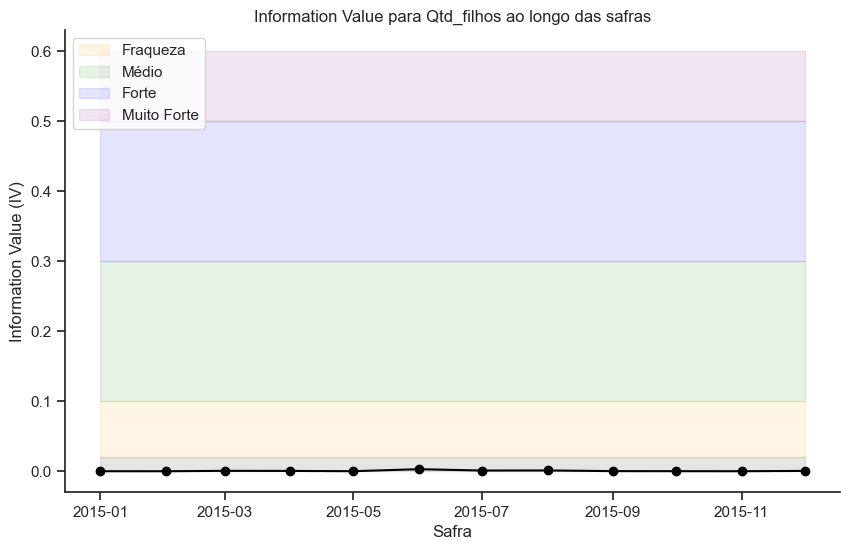

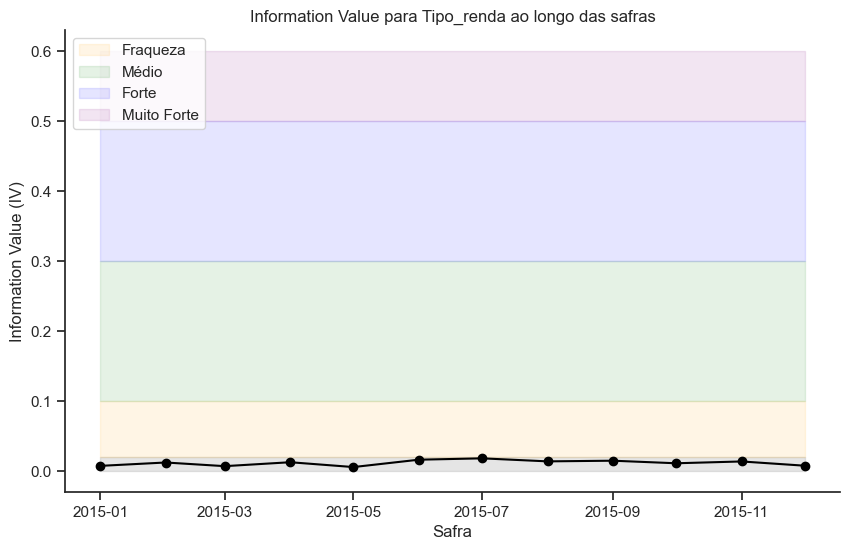

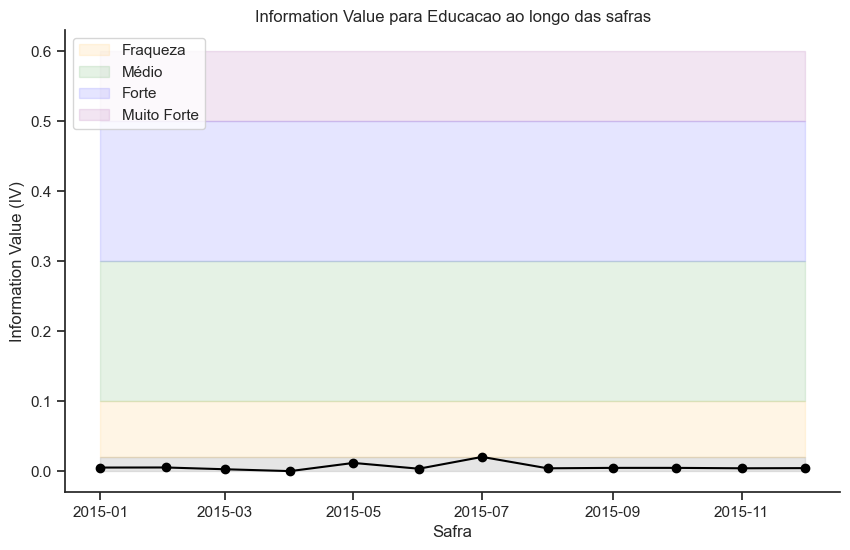

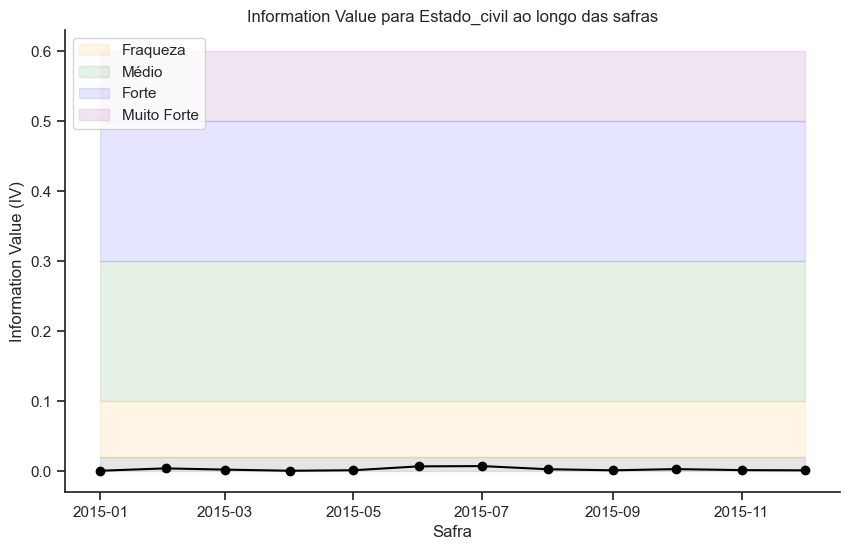

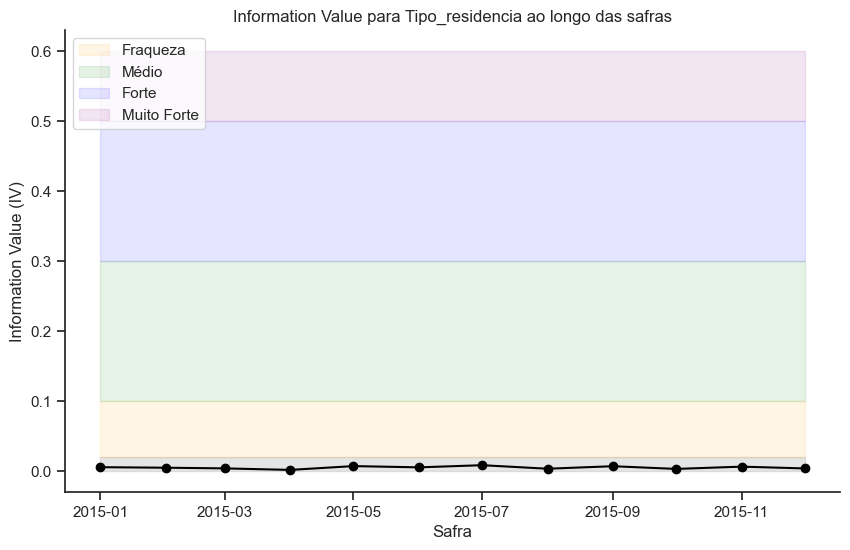

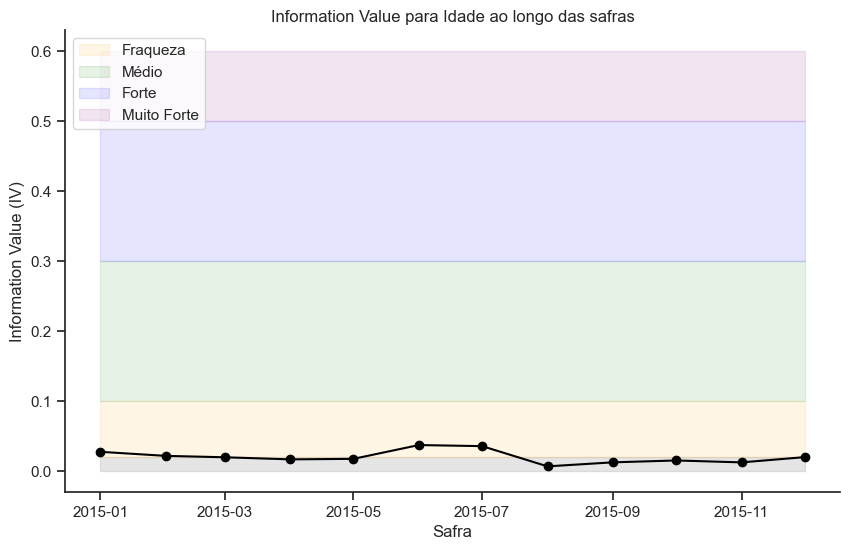

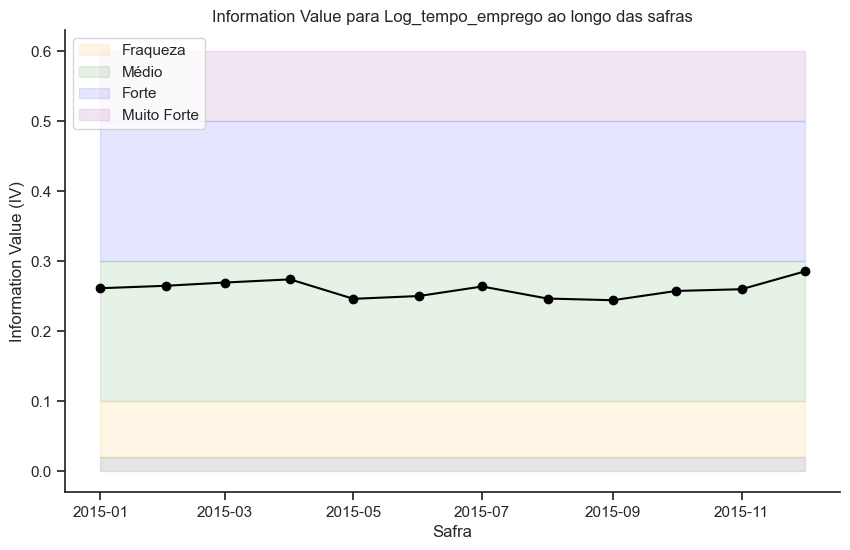

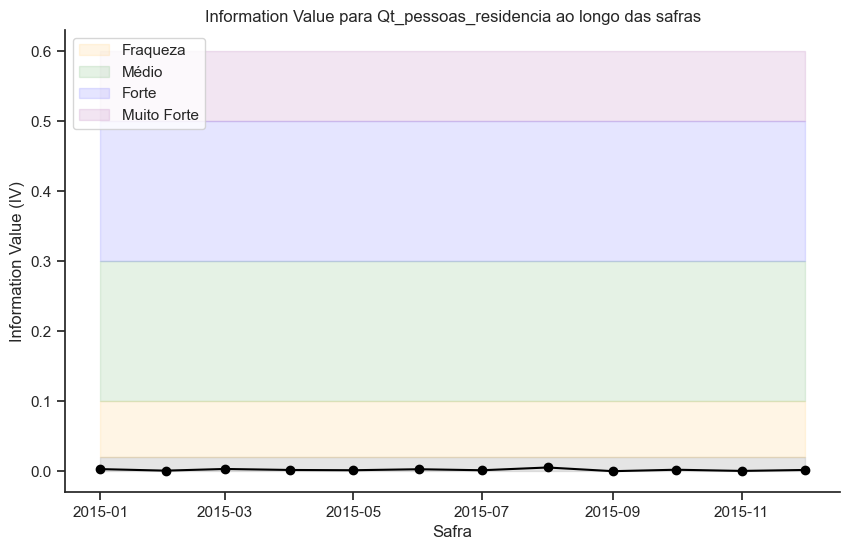

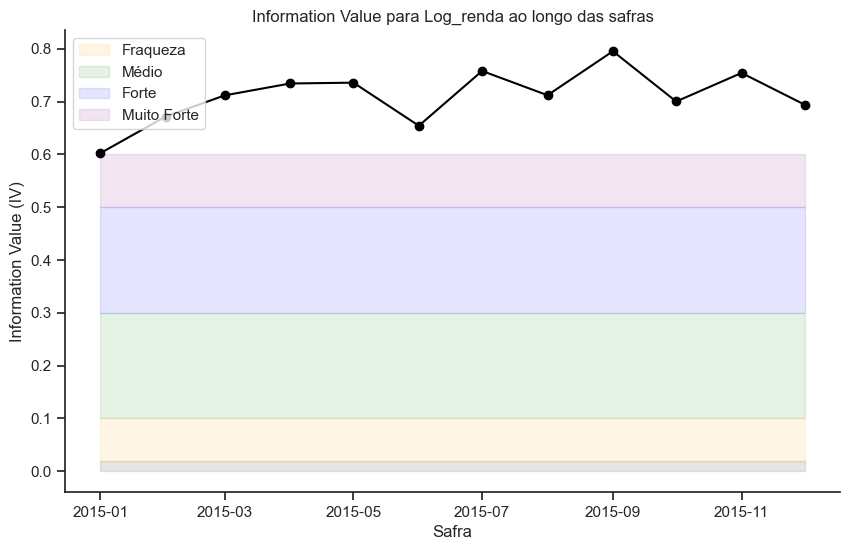

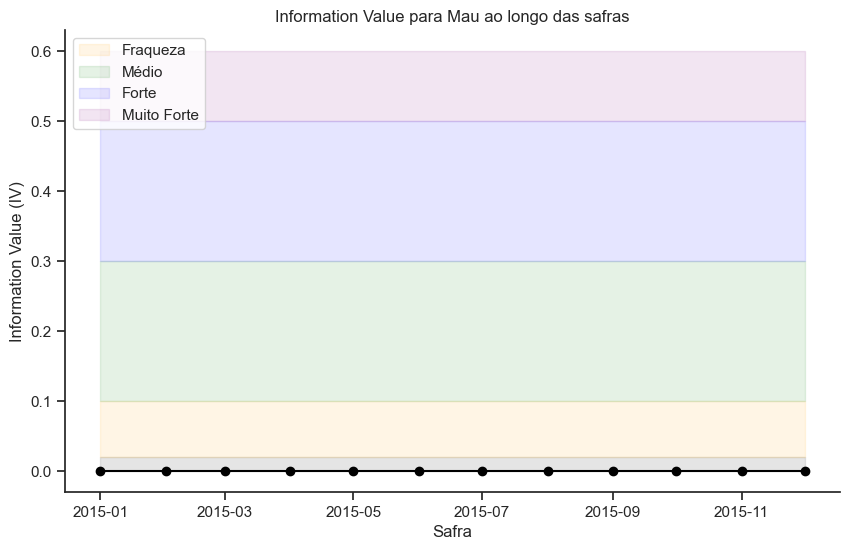

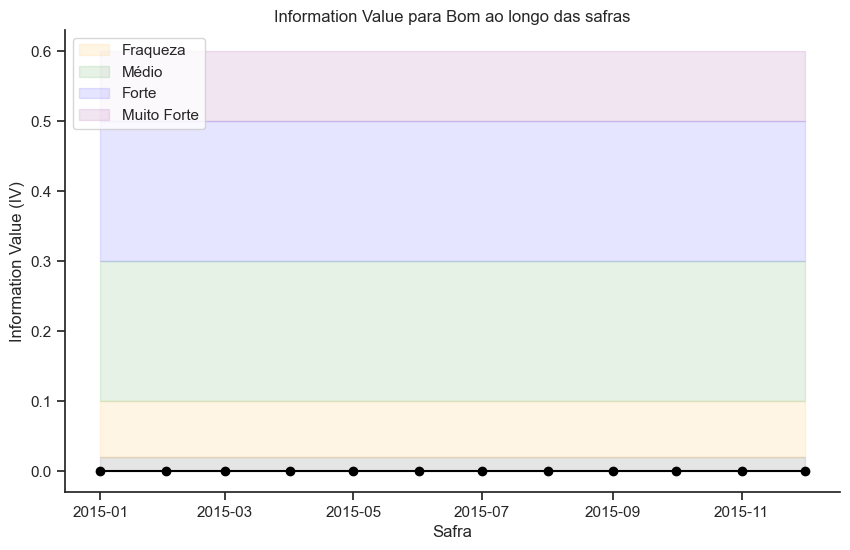

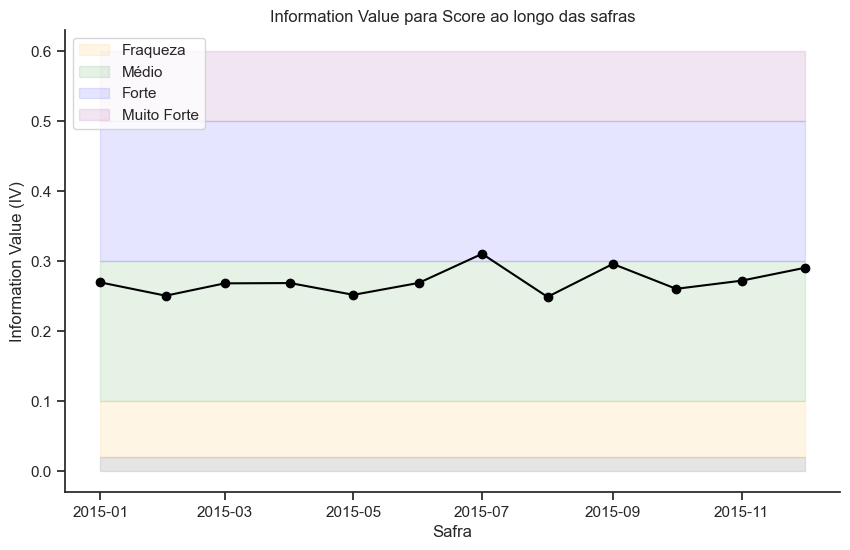

In [445]:

def calcular_iv_e_plotar(df, coluna, target='mau', bins=5):
    # Verifica se a coluna é numérica e discretiza caso seja
    if pd.api.types.is_numeric_dtype(df[coluna]):
        df['coluna_binned'] = pd.qcut(df[coluna], q=bins, duplicates='drop')
    else:
        df['coluna_binned'] = df[coluna]

    # Agrupar e calcular a frequência, taxa de evento e outros cálculos para o IV
    group = df.groupby(['data_ref', 'coluna_binned', target]).count()['tipo_residencia'].to_frame().rename(columns={"tipo_residencia": "Freq"})
    tab = group.unstack()['Freq']
    tab['N'] = tab.sum(axis=1)
    tab['tx_evento'] = tab[1] / tab.N
    tab['pct_evento'] = tab[1] / tab[1].groupby(level=0).sum()
    tab['pct_nao_evento'] = tab[0] / tab[0].groupby(level=0).sum()
    tab['WOE'] = np.log(tab['pct_evento'] / tab['pct_nao_evento'])

    # Cálculo do IV
    iv = ((tab['pct_evento'] - tab['pct_nao_evento']) * tab['WOE']).groupby(level=0).sum()
    
    # Plot do IV ao longo das safras
    fig, ax = plt.subplots(figsize=(10, 6))
    x = iv.index
    a = [.02] * len(iv.index)
    b = [.1] * len(iv.index)
    c = [.3] * len(iv.index)
    d = [.5] * len(iv.index)
    e = [.6] * len(iv.index)

    # Faixas de cores para valores de IV
    ax.fill_between(iv.index, a, color='grey', alpha=.2)
    ax.fill_between(iv.index, a, b, color='orange', alpha=.1, label="Fraqueza")
    ax.fill_between(iv.index, b, c, color='green', alpha=.1, label="Médio")
    ax.fill_between(iv.index, c, d, color='blue', alpha=.1, label="Forte")
    ax.fill_between(iv.index, d, e, color='purple', alpha=.1, label="Muito Forte")
    
    ax.plot(iv, marker='o', color='black')  # Linha do IV ao longo do tempo
    ax.set_title(f"Information Value para {coluna.capitalize()} ao longo das safras")
    ax.set_ylabel("Information Value (IV)")
    ax.set_xlabel("Safra")
    ax.legend(loc='upper left')

    plt.show()


colunas = df_.columns
colunas.drop(['mau','index','bom', 'score',])
for var in colunas:
    calcular_iv_e_plotar(df_,var)

*Basicamente a gente tem péssimas colunas discriminantes, vou tentar fazer mais algumas coisas*

In [447]:
df_['sexo'] = df_['sexo'].apply(lambda x: 1 if x== 'F' else 0)
df_['posse_de_veiculo'] = df_['posse_de_veiculo'].apply(lambda x: 1 if x== 'S' else 0)
df_['posse_de_imovel'] = df_['posse_de_imovel'].apply(lambda x: 1 if x== 'S' else 0)

df_3 = pd.get_dummies(data=df_,columns=['tipo_renda','educacao', 'estado_civil',
       'tipo_residencia'],dtype='int')


In [448]:
%%time

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, classification_report

X = df_3.drop(columns=['data_ref','index', 'mau', 'bom', 'score', 'coluna_binned'])
y = df_3['mau']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Instanciando e treinando o modelo Gradient Boosting
gbm_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbm_model.fit(X_train, y_train)

# Realizando previsões na base de teste
y_pred_proba = gbm_model.predict_proba(X_test)[:, 1]  # Probabilidade para a classe 1 (mau pagador)

# Avaliando o desempenho do modelo
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC-ROC do modelo: {roc_auc:.2f}")

# Classificação e obtenção de scores individuais
print(classification_report(y_test, gbm_model.predict(X_test)))

# Obtendo os scores de crédito para cada cliente
# Aqui, vamos considerar a probabilidade de ser bom pagador como o "score"
scores_credit = pd.DataFrame({
    'score': 1 - y_pred_proba  # Score baseado na probabilidade inversa de default
}, index=X_test.index)

# Exibindo alguns dos scores calculados
print(scores_credit.head())

AUC-ROC do modelo: 0.77
              precision    recall  f1-score   support

           0       0.94      1.00      0.97    169030
           1       0.58      0.01      0.02     10970

    accuracy                           0.94    180000
   macro avg       0.76      0.50      0.49    180000
weighted avg       0.92      0.94      0.91    180000

        score
37326   0.953
80655   0.878
372251  0.972
24920   0.849
494197  0.945
CPU times: total: 1min 30s
Wall time: 1min 34s


*Não consegui fazer com logistic regression e acabei vindo para o Gradient Boosting* 

In [450]:
df_3['score'] = gbm_model.predict_proba(df_3.drop(columns=['data_ref','index', 'mau', 'bom', 'score', 'coluna_binned']))
df_3['score']

0        0.872
33328    0.928
33329    0.757
33330    0.974
33331    0.789
          ... 
566666   0.813
566665   0.797
566664   0.950
566663   0.949
566667   0.956
Name: score, Length: 600000, dtype: float64

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [452]:
df_4 = df_.copy()
df_4= pd.get_dummies(data=df_,columns=['tipo_renda','educacao', 'estado_civil',
       'tipo_residencia'],dtype='int')
df_4['score'] = gbm_model.predict_proba(df_3.drop(columns=['data_ref','index', 'mau', 'bom', 'score', 'coluna_binned']))


In [453]:
#para manter a base 

In [454]:
def perfil_var(df, var, ev='mau', score='score', ncat=None):
    
    _df = df.copy()
    _df['ev'] = _df[ev]
    _df['nev'] = 1 - _df[ev]
    
    if ncat == None:
        g = _df.groupby(var)
    else:
        g = _df.groupby(pd.qcut(_df[var], ncat, duplicates='drop'))

    tg = g.agg({score:'mean', 'ev':'sum', 'nev':'sum'})
    tg['total'] = tg.ev + tg.nev
    tg['distribuição'] = tg.total/tg.total.sum()

    tg['total_acum'] = tg['total'].cumsum()
    tg['ev_acum']    = tg.ev.cumsum()
    tg['nev_acum']   = tg.nev.cumsum()

    tg['tx_ev']     = tg.ev/tg.total
    tg['ep']        = (tg.tx_ev*(1-tg.tx_ev)/tg.total)**.5
    tg['tx_ev_sup'] = tg.score+t.ppf([0.025], tg.total-1)*tg.ep
    tg['tx_ev_inf'] = tg.score+t.ppf([0.975], tg.total-1)*tg.ep

    fig, ax = plt.subplots()
    
    if ncat == None:
        ax.plot(tg.reset_index()[var], tg.reset_index(drop=True).score    , 'b-' , label='esperado')
        ax.plot(tg.reset_index()[var], tg.reset_index(drop=True).tx_ev    , 'r--', label='observado')
        ax.plot(tg.reset_index()[var], tg.reset_index(drop=True).tx_ev_sup, 'r:',  label='obs-ls')
        ax.plot(tg.reset_index()[var], tg.reset_index(drop=True).tx_ev_inf, 'r:',  label='obs-li')
    else:
        tg[var+'_med'] = g[var].mean()
        ax.plot(tg[var+'_med'], tg.reset_index(drop=True).score    , 'b-' , label='esperado')
        ax.plot(tg[var+'_med'], tg.reset_index(drop=True).tx_ev    , 'r--', label='observado')
        ax.plot(tg[var+'_med'], tg.reset_index(drop=True).tx_ev_sup, 'r:',  label='obs-ls')
        ax.plot(tg[var+'_med'], tg.reset_index(drop=True).tx_ev_inf, 'r:',  label='obs-li')
    return tg[['distribuição', score, 'tx_ev']]



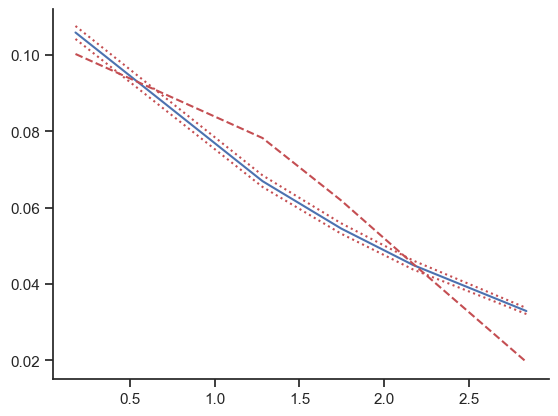

In [455]:
tg = perfil_var(df_, 'log_tempo_emprego', ncat=5)

,distribuição,score,tx_ev
idade,,,
"(21.999, 33.0]",0.225,0.074,0.074
"(33.0, 40.0]",0.206,0.062,0.062
"(40.0, 47.0]",0.192,0.058,0.056
"(47.0, 55.0]",0.183,0.052,0.051
"(55.0, 68.0]",0.194,0.058,0.059


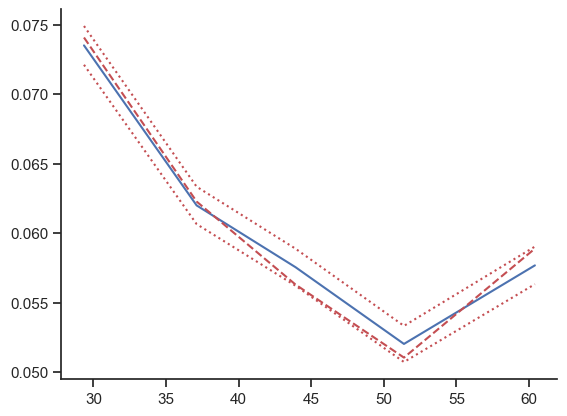

In [456]:
tg = perfil_var(df_, 'idade', ncat=5)
tg

,distribuição,score,tx_ev
score,,,
"(0.013999999999999999, 0.0379]",0.200,0.031,0.021
"(0.0379, 0.0485]",0.200,0.043,0.044
"(0.0485, 0.0602]",0.200,0.054,0.059
"(0.0602, 0.0785]",0.200,0.068,0.077
"(0.0785, 0.313]",0.200,0.109,0.105


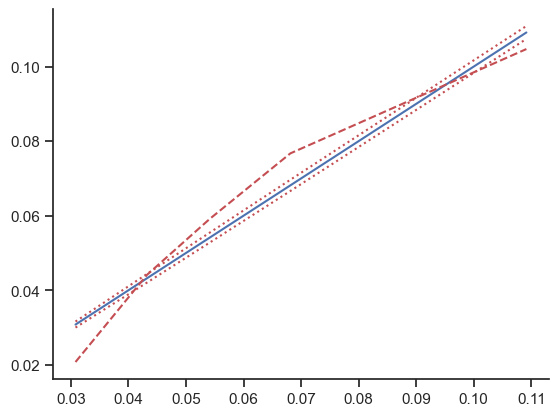

In [457]:
perfil_var(df_, 'score', ncat=5)

In [458]:
#fiz uma copia do df original para n estragar dados caso precise voltar algum momento

In [459]:
df5 = df_out_of_time.copy()
df5.loc[:,'renda'] = np.log(df5['renda'])
df5.rename(columns={'renda':'log_renda'},inplace=True)
df5.loc[:,'tempo_emprego'] = np.log(df5['tempo_emprego'])
df5.rename(columns={'tempo_emprego':'log_tempo_emprego'},inplace=True)
df5['sexo'] = df5['sexo'].apply(lambda x: 1 if x== 'F' else 0)
df5['posse_de_veiculo'] = df5['posse_de_veiculo'].apply(lambda x: 1 if x== 'S' else 0)
df5['posse_de_imovel'] = df5['posse_de_imovel'].apply(lambda x: 1 if x== 'S' else 0)


In [460]:
df5 = pd.get_dummies(data=df5,columns=['tipo_renda','educacao', 'estado_civil',
       'tipo_residencia'],dtype='int')

# Preenche valores ausentes com a média de cada coluna
imputer = SimpleImputer(strategy='mean')
df5_imputed = pd.DataFrame(imputer.fit_transform(df5.drop(columns=['data_ref', 'index', 'mau'])),
                           columns=df5.drop(columns=['data_ref', 'index', 'mau']).columns)

# Calcula as probabilidades e previsões
df5['score'] = gbm_model.predict_proba(df5_imputed)[:, 1]
df5['predict'] = gbm_model.predict(df5_imputed)


In [461]:
y_true = df5['mau']          
y_pred = df5['predict']          
y_score = df5['score']            

accuracy = accuracy_score(y_true, y_pred)
print(f"Acurácia: {accuracy:.2f}")

auc_roc = roc_auc_score(y_true, y_score)
print(f"AUC-ROC: {auc_roc:.2f}")

score_class_0 = y_score[y_true == 0]
score_class_1 = y_score[y_true == 1]

ks_stat, _ = stats.ks_2samp(score_class_0, score_class_1)
print(f"Estatística KS: {ks_stat:.2f}")


gini = 2 * auc_roc - 1
print(f"Gini: {gini:.2f}")

print("\n                  Relatório de Classificação:")
print('-='*27)
print(classification_report(y_true, y_pred))


Acurácia: 0.85
AUC-ROC: 0.74
Estatística KS: 0.35
Gini: 0.48

                  Relatório de Classificação:
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
              precision    recall  f1-score   support

       False       0.86      0.99      0.92    128000
        True       0.54      0.05      0.09     22000

    accuracy                           0.85    150000
   macro avg       0.70      0.52      0.51    150000
weighted avg       0.81      0.85      0.80    150000

